In [60]:
# https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download

In [61]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from prettytable import PrettyTable

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('WA_Telco_Customer_Churn.csv')

In [63]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [64]:
def df_explore(df):
    #Armamos una funcion para tener el detalle de todas las variables
    print( 'Shape: ', df.shape)
    
    t = PrettyTable(['Column', 
                     'Type',
                     'Non-Null',
                     'Nulls',
                     'Nulls %',
                     'Unique',
                     'Example',
                    ])
    
    for c in df.columns:
        t.add_row([c,
                   df[c].dtype,
                   len(df[c])-np.sum(df[c].isna()),
                   np.sum(df[c].isna()),
                   round((np.sum(df[c].isna())/(len(df[c])-np.sum(df[c].isna())))*100,2),
                   np.count_nonzero(df[c].unique()),
                   df[~df[c].isnull()][c].iloc[0],
                  ]) 
    print(t)
    print()
    return

df_explore(df)

Shape:  (7043, 21)
+------------------+---------+----------+-------+---------+--------+------------------+
|      Column      |   Type  | Non-Null | Nulls | Nulls % | Unique |     Example      |
+------------------+---------+----------+-------+---------+--------+------------------+
|    customerID    |  object |   7043   |   0   |   0.0   |  7043  |    7590-VHVEG    |
|      gender      |  object |   7043   |   0   |   0.0   |   2    |      Female      |
|  SeniorCitizen   |  int64  |   7043   |   0   |   0.0   |   1    |        0         |
|     Partner      |  object |   7043   |   0   |   0.0   |   2    |       Yes        |
|    Dependents    |  object |   7043   |   0   |   0.0   |   2    |        No        |
|      tenure      |  int64  |   7043   |   0   |   0.0   |   72   |        1         |
|   PhoneService   |  object |   7043   |   0   |   0.0   |   2    |        No        |
|  MultipleLines   |  object |   7043   |   0   |   0.0   |   3    | No phone service |
| InternetSer

In [65]:
df = df.drop(['customerID'], axis=1)

In [66]:
#On deep analysis, we can find some indirect missingness in our data (which can be in form of blankspaces). Let's see that!
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [67]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [68]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : gender SeniorCitizen Partner Dependents PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod Churn
Numerical Features : tenure MonthlyCharges TotalCharges


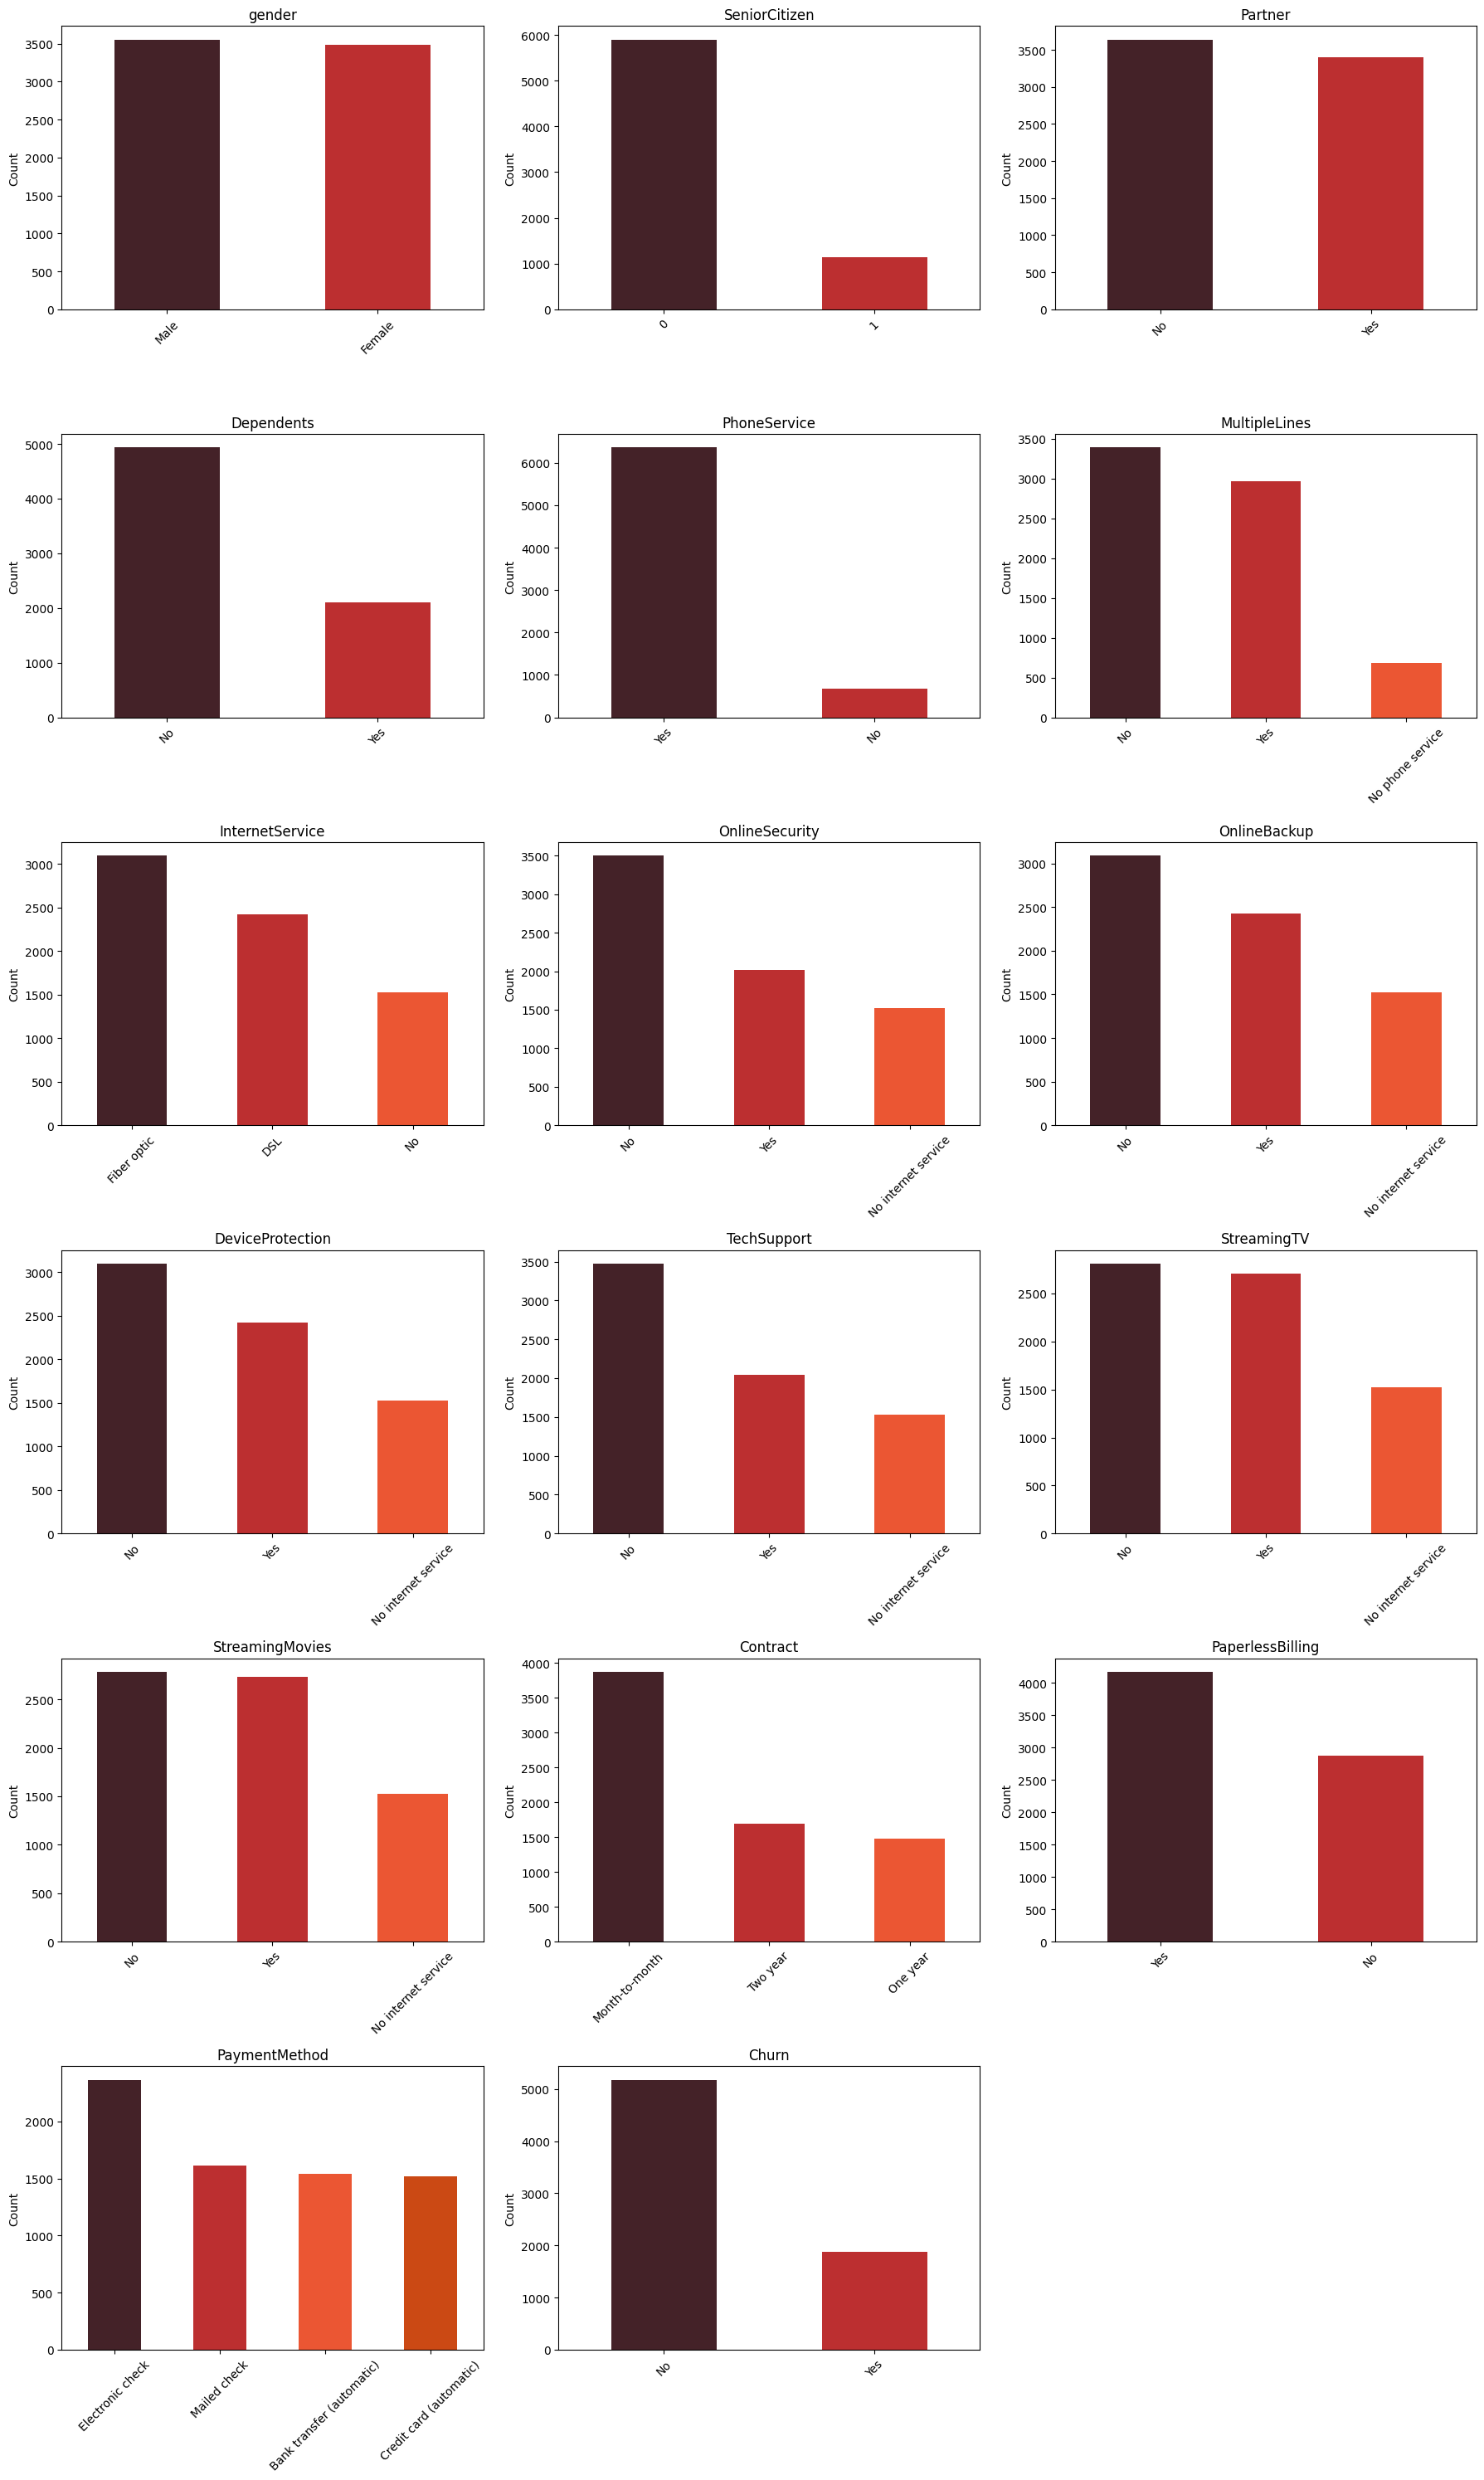

In [69]:
# Number of columns in subplot grid
colors = ['#442228','#BC2F30','#EB5633','#CB4914','#AA090A']

n_cols = 3
n_rows = math.ceil(len(categorical_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    df[col].value_counts().plot(
        kind='bar',
        ax=axes[i],
        color=colors
    )
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **Bivariate analysis** ###

In [70]:
categorical_features.remove('Churn')
# We will remove Churn, target variable, from the categorical features list for visualization purposes.

In [71]:
l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

### **Categorical Features vs Target Variable (Churn):** ###

##### **Group 1** #####
##### **Customer Information :  Gender | SeniorCitizen | Partner | Dependents** #####


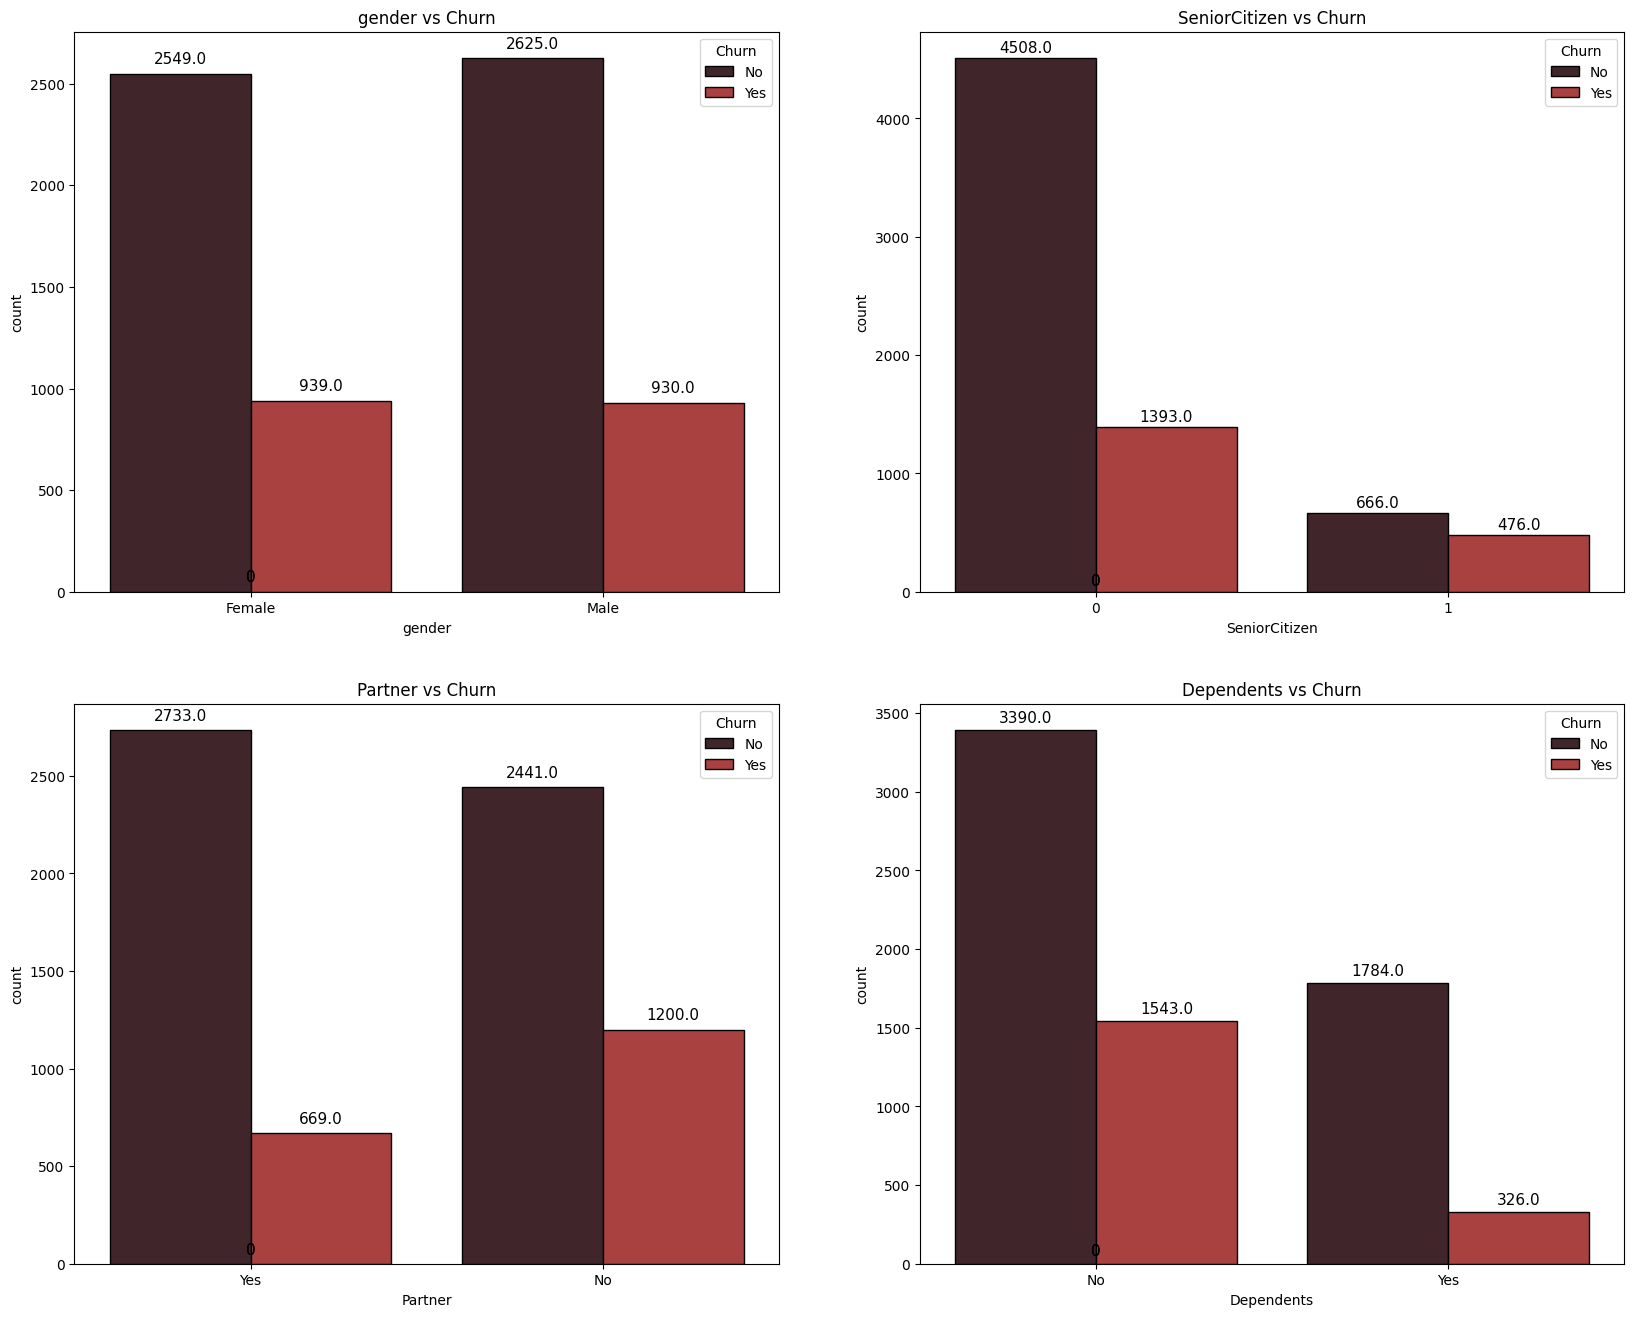

In [72]:
churn_colors = ['#3498db', '#e74c3c'] 

fig = plt.subplots(nrows = 2, ncols = 2, figsize = (20,16))

for i in range(len(l1)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(data=df, x=l1[i], hue="Churn", palette=colors[:2], edgecolor='black')
    
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
                rect.get_height(), horizontalalignment='center', fontsize=11)
    
    title = l1[i] + ' vs Churn'
    plt.title(title)

- Customer churning for male & female customers is very similar to each other!
- Similarly, number of SeniorCitizen customers is pretty low! Out of that, we can observe a near about 40% churn of SeniorCitizen customers. It accounts for a total of 476 customers out of 1142 Senior Citizen customers.
- Customers who are housing with a Partner churned less as compared to those not living with a Partner.
- Similary, churning is high for the customers that don't have Dependents with them!

##### **Group 2** #####
##### **Services Subscribed by the Customer:  PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies** #####


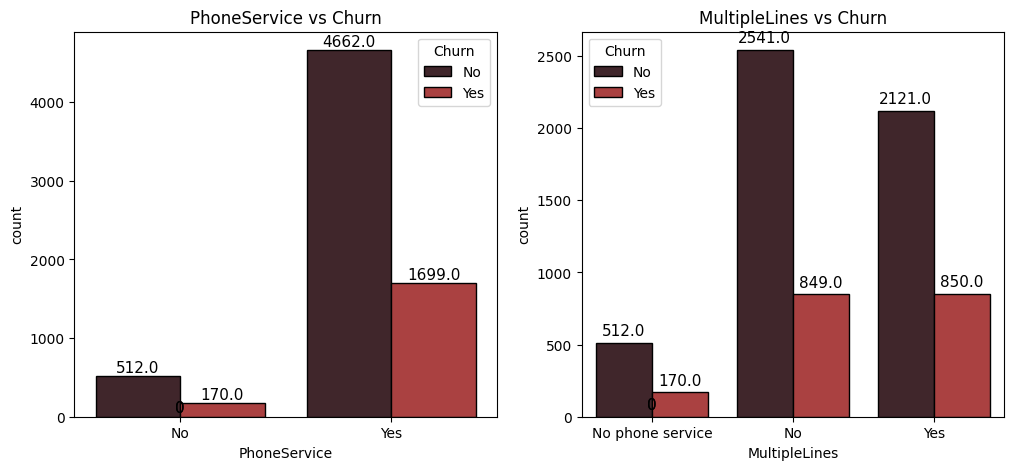

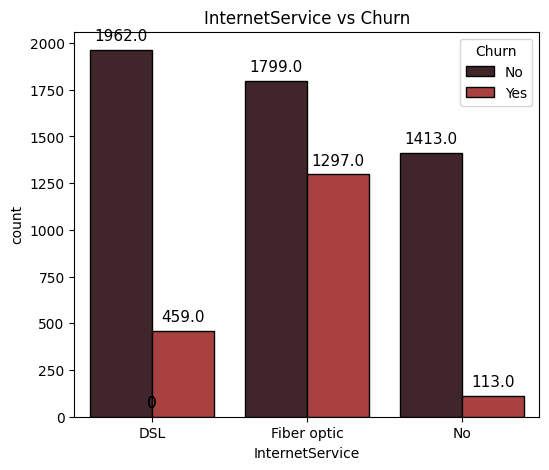

In [73]:
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(data=df, x=l2[i], hue="Churn", palette=colors[:2], edgecolor='black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
                rect.get_height(), horizontalalignment='center', fontsize=11)
    title = l2[i] + ' vs Churn'
    plt.title(title)

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))
plt.subplot(1,1,1)
ax = sns.countplot(data=df, x=l2[2], hue="Churn", palette=colors[:2], edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
            rect.get_height(), horizontalalignment='center', fontsize=11)
title = l2[2] + ' vs Churn'
plt.title(title)
    
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(data=df, x=l2[i + 3], hue="Churn", palette=colors[:2], edgecolor='black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
                rect.get_height(), horizontalalignment='center', fontsize=11)
    title = l2[i + 3] + ' vs Churn'
    plt.title(title)

- For PhoneService, despite having no phone service, more customers were retained as compared to the number of customers who dropped the services. 
- In case of MultipleLines, churn rate in when the Multiplelines are present or not is the same.
- A high number of customers have displayed their resistance towards the use of Fiber optic cables for providing the InternetService. On the contrary, from the above graph, customers prefer using DSL for their InternetService!
- StreamingTV and StreamingMovies display an identical graph. Irrespective of being subscribed to StreamingTV & StreamingMovies, a lot of customers have been churned. Looks like the streaming content was not entirely at fault!

##### **Group 2** #####
##### **Services Subscribed by the Customer:  OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport** #####


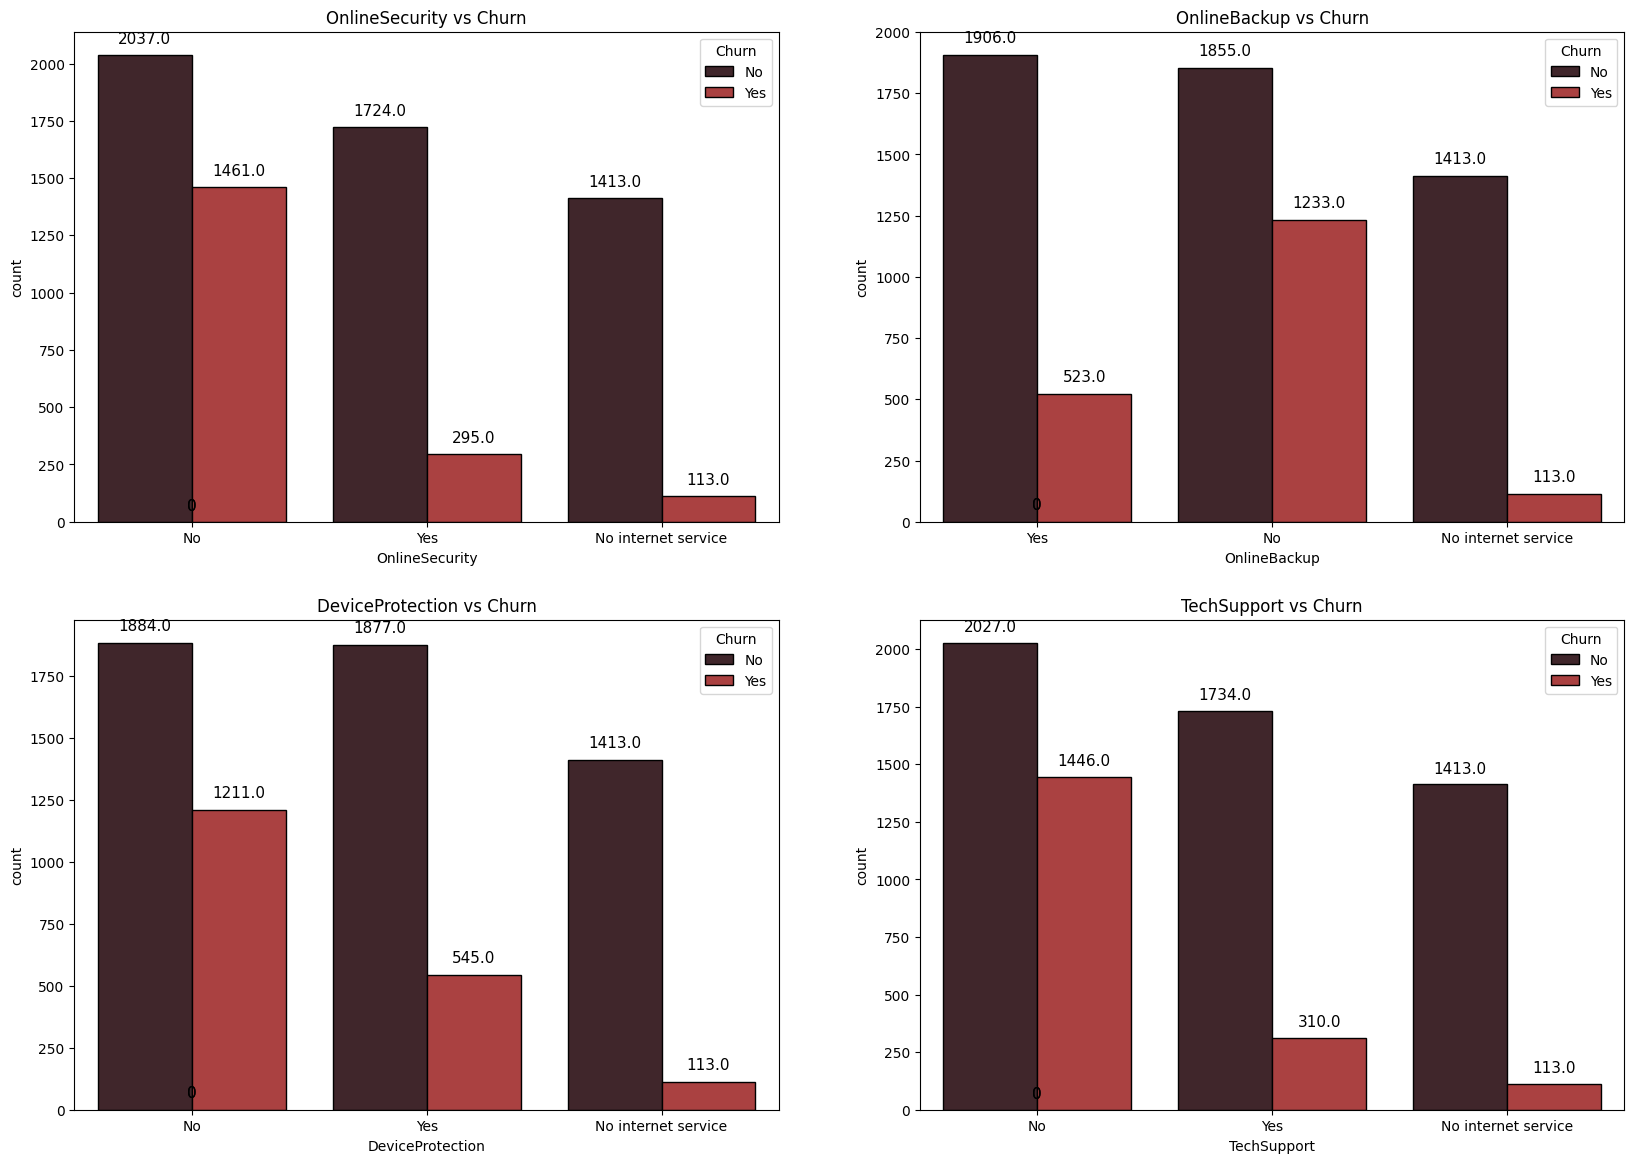

In [74]:
fig = plt.subplots(nrows = 2, ncols = 2, figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.countplot(data=df, x=l2[-4 + i], hue="Churn", palette=colors[:2], edgecolor='black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
                rect.get_height(), horizontalalignment='center', fontsize=11)
    title = l2[-4 + i] + ' vs Churn'
    plt.title(title)

- When it comes down to catering the customers, services w.r.t OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport are crucial from the above visualizations!
- A high number of customers have switched their service provider when it comes down poor services with the above mentioned features.

##### **Group 3** #####
##### **Services Subscribed by the Customer:  Contract | PaperlessBilling | PaymentMethod** #####


Text(0.5, 1.0, 'PaymentMethod vs Churn')

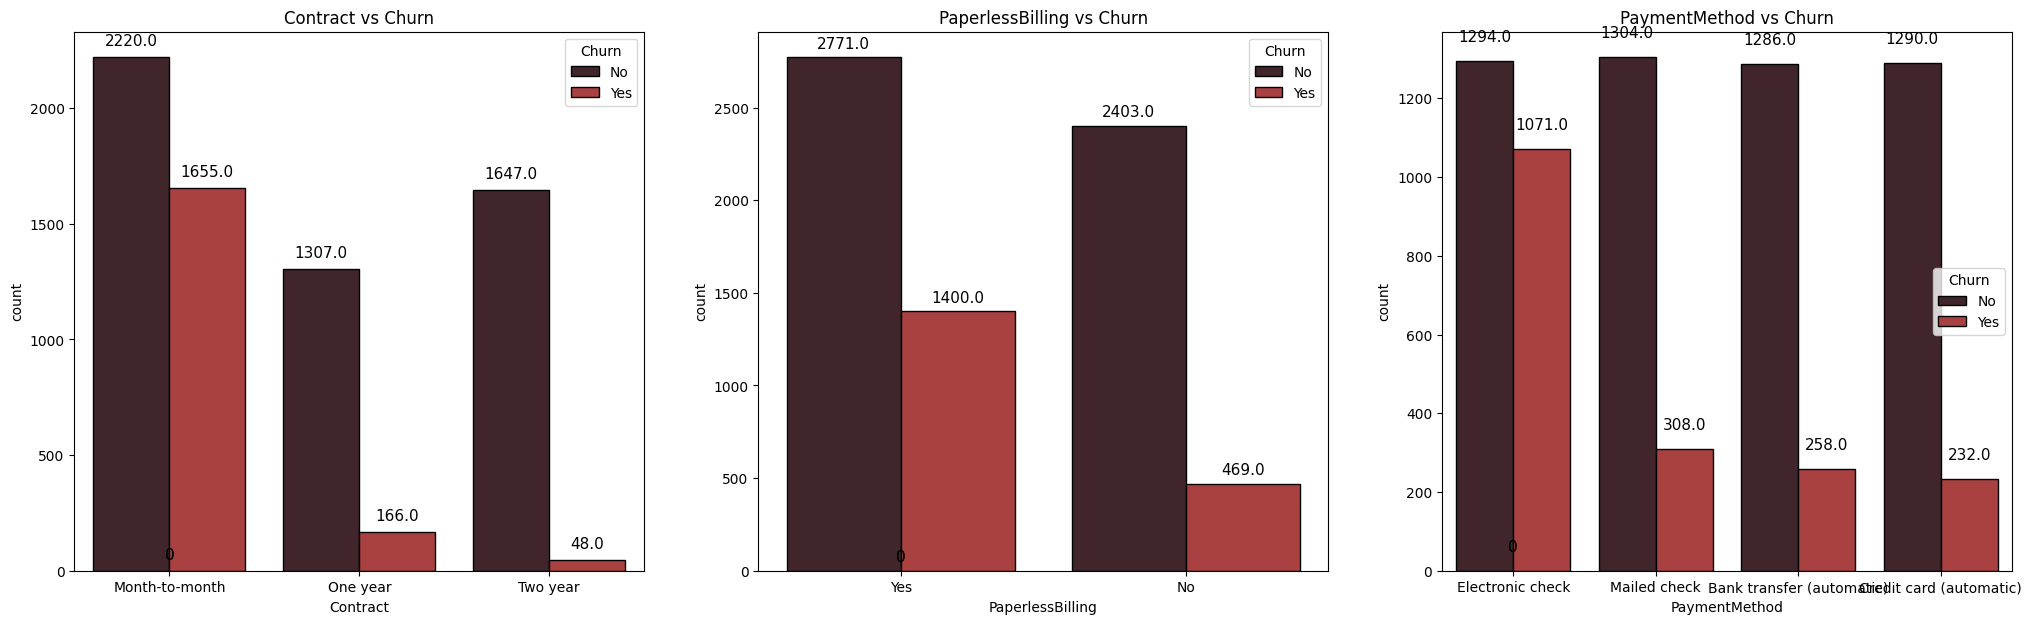

In [75]:
fig = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))

plt.subplot(1,3,1)
ax = sns.countplot(data=df, x=l3[0], hue="Churn", palette=colors[:2], edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
            rect.get_height(), horizontalalignment='center', fontsize=11)
title = l3[0] + ' vs Churn'
plt.title(title)

plt.subplot(1,3,2)
ax = sns.countplot(data=df, x=l3[1], hue="Churn", palette=colors[:2], edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
            rect.get_height(), horizontalalignment='center', fontsize=11)
title = l3[1] + ' vs Churn'
plt.title(title)

plt.subplot(1,3,3)
ax = sns.countplot(data=df, x=l3[2], hue="Churn", palette=colors[:2], edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 50, 
            rect.get_height(), horizontalalignment='center', fontsize=11)
title = l3[2] + ' vs Churn'
plt.title(title)

- Customer churning for a Month-to-Month based Contract is quite high. This is probably because the customers are testing out the varied services available to them and hence, in order to save money, 1 month service is tested out!
- Another reason can be the overall experience with the internet service, streaming service and phone service were not consistent. Every customer has a different priority and hence if one of the 3 was upto par, the entire service was cutoff!
- PaperlessBilling displays a high number of customers being churned out. This is probably because of some payment issue or receipt issues.
- Customers clearly resented the Electronic check PaymentMethod. Out of the 2365 number of bills paid using Electronic check, a staggering 1071 customers exited the pool of service due to this payment method. Company definitely needs to either drop Electronic check method or make it hassle-free and user-friendly.

### **Categorical Features vs Positive Target Variable (Churn Cases) :** ###

In [76]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1 = df.copy(deep = True)
text_data_features = [i for i in list(df.columns) if i not in list(df.describe().columns)]

print('Label Encoder Transformation')
for i in text_data_features :
    df1[i] = le.fit_transform(df1[i])
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  :  [0 1]  =  ['No' 'Yes']


- We creating a deep copy of the orginal dataset and label encoding the text data.
- Modifications in the original dataset will not be highlighted in this deep copy.
- Hence, we use this deep copy of dataset that has all the features converted into numerical values for visualization & modeling purposes.
- We now again the descriptive stats of the data.

##### **Group 1** #####
##### **Customer Information:  Gender | SeniorCitizen | Partner | Dependents** #####


In [77]:
gender = df1[df1['Churn'] == 1]['gender'].value_counts()
gender = [gender[0] / sum(gender) * 100, gender[1] / sum(gender) * 100] # Female / Male

seniorcitizen = df1[df1['Churn'] == 1]['SeniorCitizen'].value_counts()
seniorcitizen = [seniorcitizen[0] / sum(seniorcitizen) * 100,seniorcitizen[1] / sum(seniorcitizen) * 100] # No - Yes

partner = df1[df1['Churn'] == 1]['Partner'].value_counts()
partner = [partner[0] / sum(partner) * 100,partner[1] / sum(partner) * 100] # No - Yes

dependents = df1[df1['Churn'] == 1]['Dependents'].value_counts()
dependents = [dependents[0] / sum(dependents) * 100,dependents[1] / sum(dependents) * 100] # No - Yes

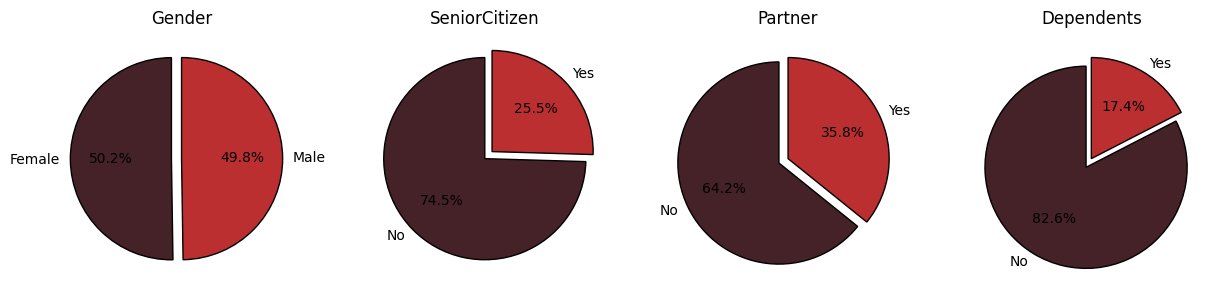

In [78]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(gender,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Gender');

plt.subplot(1,4,2)
plt.pie(seniorcitizen,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('SeniorCitizen');

plt.subplot(1,4,3)
plt.pie(partner,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Partner');

plt.subplot(1,4,4)
plt.pie(dependents,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Dependents');

- We can observe a clear cut 50% - 50% split between the male and female customers that have switched their services. Hence, the reason for switching is something related to the service or some process which the customers reacted badly!
- 75% of the churned customers are not SeniorCitizen! This is a major info that the company needs to divert it's attention towards!
- Customers living by themselves have cutoff the services. From Partners & Dependents data, average of 73.4% of customers churned out were living by themselves.

##### **Group 2** #####
##### **Services Subscribed by the Customer :  PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies** #####


In [79]:
phoneservice = df1[df1['Churn'] == 1]['PhoneService'].value_counts()
phoneservice = [phoneservice[0] / sum(phoneservice) * 100, phoneservice[1] / sum(phoneservice) * 100] # No - Yes

multiplelines = df1[df1['Churn'] == 1]['MultipleLines'].value_counts()
multiplelines = [multiplelines[0] / sum(multiplelines) * 100,multiplelines[1] / sum(multiplelines) * 100, multiplelines[2] / sum(multiplelines) * 100] # No - No Phone Service - Yes 

internetservice = df1[df1['Churn'] == 1]['InternetService'].value_counts()
internetservice = [internetservice[0] / sum(internetservice) * 100,internetservice[1] / sum(internetservice) * 100, internetservice[2] / sum(internetservice) * 100] # DSL - Fiber Optic - No 

streamingtv = df1[df1['Churn'] == 1]['StreamingTV'].value_counts()
streamingtv = [streamingtv[0] / sum(streamingtv) * 100,streamingtv[1] / sum(streamingtv) * 100, streamingtv[2] / sum(streamingtv) * 100] # No - No Internet Service - Yes 

streamingmovies = df1[df1['Churn'] == 1]['StreamingMovies'].value_counts()
streamingmovies = [streamingmovies[0] / sum(streamingmovies) * 100,streamingmovies[1] / sum(streamingmovies) * 100, streamingmovies[2] / sum(streamingmovies) * 100] # No - No Internet Service - Yes 

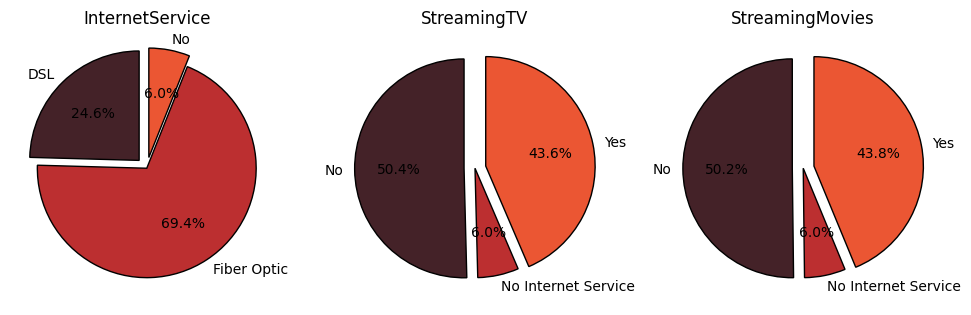

In [80]:
ax,fig = plt.subplots(nrows = 1,ncols = 2,figsize = (8,8))

plt.subplot(1,2,1)
plt.pie(phoneservice,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PhoneService');

plt.subplot(1,2,2)
plt.pie(multiplelines,labels = ['No','No Phone Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('MultipleLines');

ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(internetservice,labels = ['DSL', 'Fiber Optic','No'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('InternetService');

plt.subplot(1,3,2)
plt.pie(streamingtv,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingTV');

plt.subplot(1,3,3)
plt.pie(streamingmovies,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingMovies');

- Despite providing PhoneService, a high percentage of customers have switched!
- Similarly, availability of MultipleLines did not matter, as customer unsubscription was carried out regardless!
- Customers definitely did not appreciate the approach of Fiber Optic cables for providing InternetService with a solid 70% opting out from the services!
- For StreamingTV & StreamingMovies, customers without these services definitely cancelled their subscription, however an average of 43.7% of customers switched despite consuming the streaming content.

##### **Group 2** #####
##### **Services Subscribed by the Customer :  OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport** #####


In [81]:
onlinesecurity = df1[df1['Churn'] == 1]['OnlineSecurity'].value_counts()
onlinesecurity = [onlinesecurity[0] / sum(onlinesecurity) * 100,onlinesecurity[1] / sum(onlinesecurity) * 100, onlinesecurity[2] / sum(onlinesecurity) * 100] # No - No Internet Service - Yes 

onlinebackup = df1[df1['Churn'] == 1]['OnlineBackup'].value_counts()
onlinebackup = [onlinebackup[0] / sum(onlinebackup) * 100,onlinebackup[1] / sum(onlinebackup) * 100, onlinebackup[2] / sum(onlinebackup) * 100] # No - No Internet Service - Yes 

deviceprotection = df1[df1['Churn'] == 1]['DeviceProtection'].value_counts()
deviceprotection = [deviceprotection[0] / sum(deviceprotection) * 100,deviceprotection[1] / sum(deviceprotection) * 100, deviceprotection[2] / sum(deviceprotection) * 100] # No - No Internet Service - Yes 

techsupport = df1[df1['Churn'] == 1]['TechSupport'].value_counts()
techsupport = [techsupport[0] / sum(techsupport) * 100,techsupport[1] / sum(techsupport) * 100, techsupport[2] / sum(techsupport) * 100] # No - No Internet Service - Yes 

In [82]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(onlinesecurity,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineSecurity');

plt.subplot(1,4,2)
plt.pie(onlinebackup,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineBackup');

plt.subplot(1,4,3)
plt.pie(deviceprotection,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('DeviceProtection');

plt.subplot(1,4,4)
plt.pie(techsupport,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('TechSupport');

- Above pie charts stress out the significance of providing OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport as an average of 71.6% customers cutoff their services due to lack of these features!

##### **Group 3** #####
##### **Services Subscribed by the Customer :  Contract | PaperlessBilling | PaymentMethod** #####


In [83]:
contract = df1[df1['Churn'] == 1]['Contract'].value_counts()
contract = [contract[0] / sum(contract) * 100, contract[1] / sum(contract) * 100, contract[2] / sum(contract) * 100] # Month-to-month - One year - Two year

paperlessbilling = df1[df1['Churn'] == 1]['PaperlessBilling'].value_counts()
paperlessbilling = [paperlessbilling[0] / sum(paperlessbilling) * 100,paperlessbilling[1] / sum(paperlessbilling) * 100] # No - Yes 

paymentmethod = df1[df1['Churn'] == 1]['PaymentMethod'].value_counts()
paymentmethod = [paymentmethod[0] / sum(paymentmethod) * 100, paymentmethod[1] / sum(paymentmethod) * 100, 
            paymentmethod[2] / sum(paymentmethod) * 100, paymentmethod[3] / sum(paymentmethod) * 100] 
            # Bank Transfer (automatic) - Credit Card (automatic) - Electronic check - Mailed check

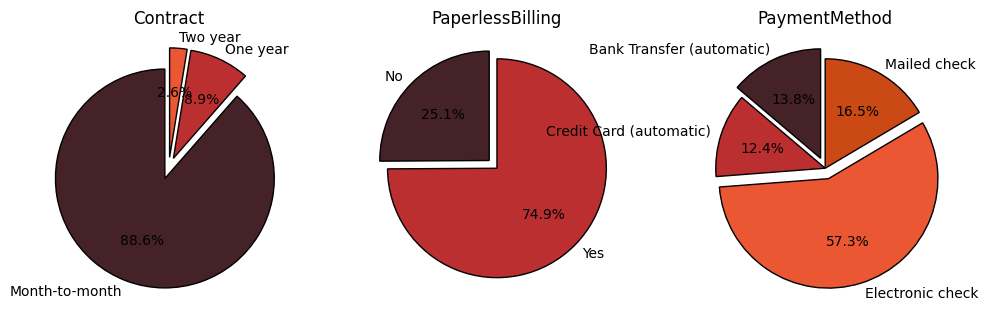

In [84]:
ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(contract,labels = ['Month-to-month','One year','Two year'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Contract');

plt.subplot(1,3,2)
plt.pie(paperlessbilling,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaperlessBilling');

plt.subplot(1,3,3)
plt.pie(paymentmethod,labels = ['Bank Transfer (automatic)','Credit Card (automatic)','Electronic check','Mailed check'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaymentMethod');

- onth-to-Month Contract duration has the dominating share when it comes churning with a massive 88.6% customers!
- PaperlessBilling does not seemed to be appreciated by the customers!
- Electronic check definitely needs to be sorted as it accounts for 57.3% of churn. It is then followed by Mailed check, Bank Transfer (automatic) & Credit Card (automatic)!

##### **Numerical Features** #####


##### **Distribution of Numerical Features :** #####


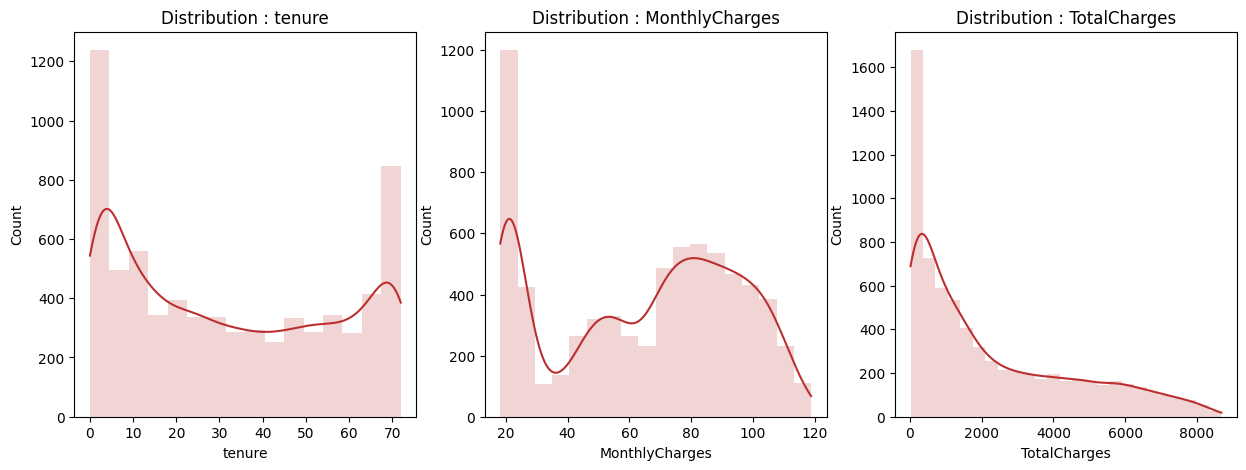

In [85]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(len(numerical_features)):
    plt.subplot(1,3,i+1)
    sns.histplot(df1[numerical_features[i]],color = colors[1], kde=True, edgecolor=None, alpha=0.2)
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

- tenure and MonthlyCharges kind of create a bimodal distribution with peaks present at 0 - 70 and 20 - 80 respectively.
- TotalCharges displays a positively or rightly skewed distribution.

##### **Numerical Features w.r.t Target Variable (Outcome) :** #####


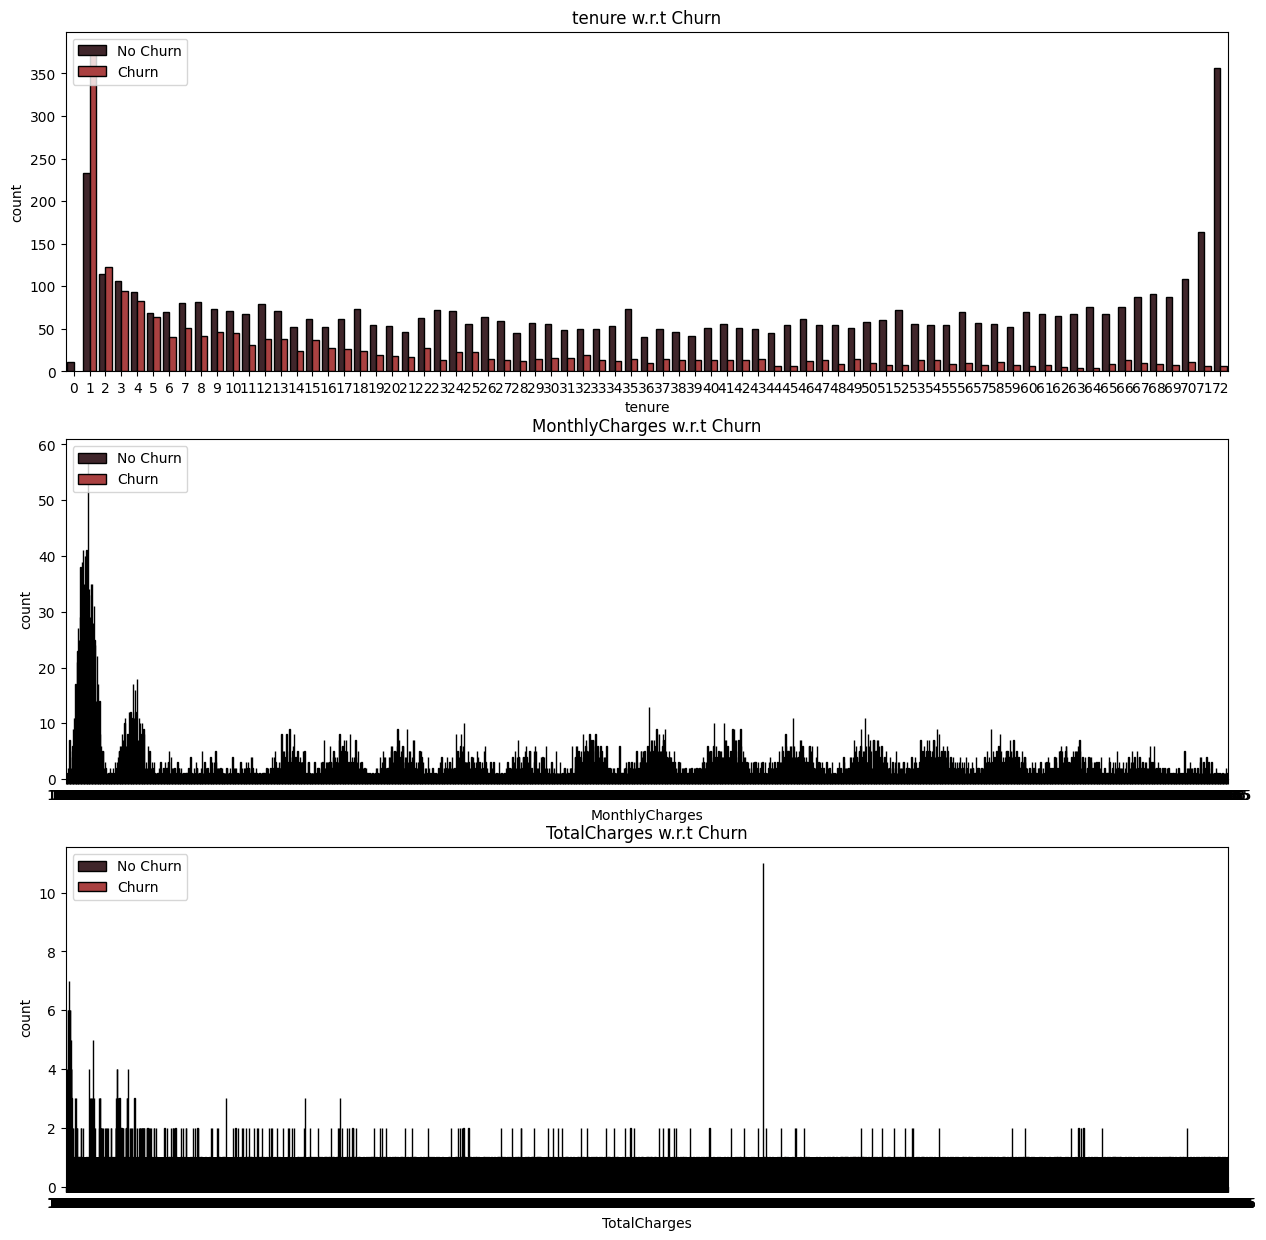

In [86]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,1,i+1)
    sns.countplot(data=df1, x=numerical_features[i], hue="Churn", palette=colors[:2], edgecolor='black')
    plt.legend(['No Churn','Churn'], loc='upper left')
    title = numerical_features[i] + ' w.r.t Churn'
    plt.title(title)

- Considering tenure, a high number of customers have left after the 1st month. This high cancellation of services continues for 4 - 5 months but the churn customers have reduced since the 1st month. As the tenure increases, customers dropping out decreases.
- This results in low customer churning as the tenure increases. It displays a symmetrical graph with the left side dominating with churn numbers and right side dominating with low churn numbers.
- Because of too many unique data points in MonthlyCharges & TotalCharges, it is difficult to gain any type of insight. Thus, we will scale these numerical features for understandable visualization and gaining insights purposes. This brings the varied data points to a constant value that represents a range of values.
- Here, we divide the data points of the numerical features by 5 or 500 and assign its quotient value as the representative constant for that data point. The scaling constants are decided by looking into the data & intuition.

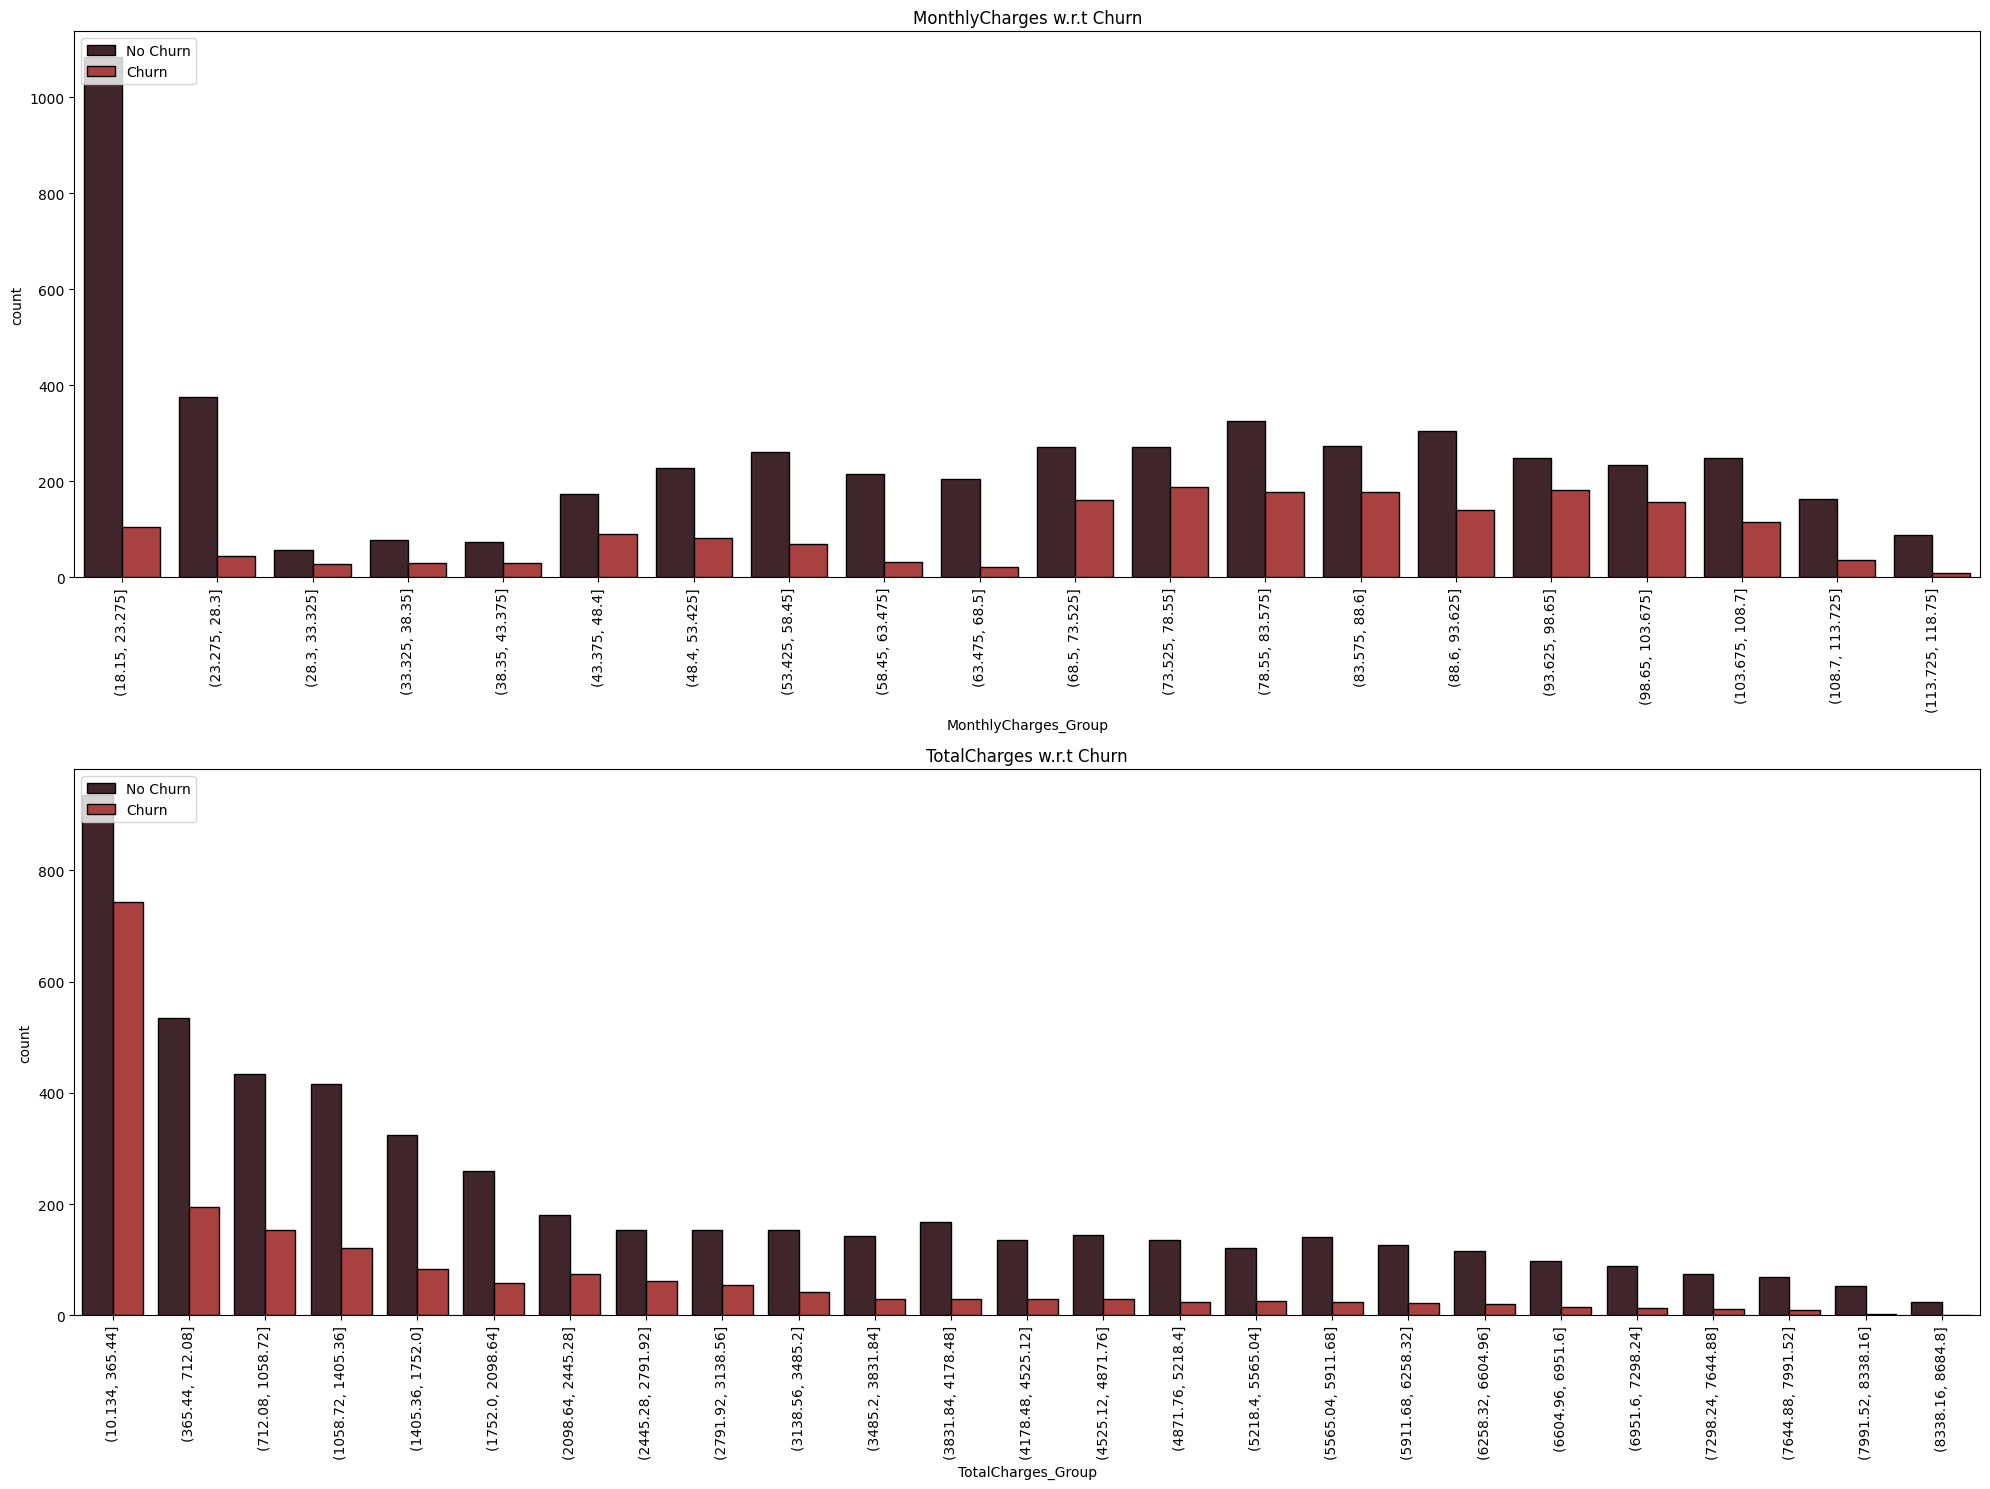

In [87]:
df1['MonthlyCharges_Group'] = pd.cut(df1['MonthlyCharges'], bins=20)
df1['TotalCharges_Group'] = pd.cut(df1['TotalCharges'], bins=25)

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20,15))
for i in range(len(numerical_features[1:])):
    plt.subplot(2,1,i+1)
    sns.countplot(data=df1, x=numerical_features[1 + i]+'_Group', hue="Churn", 
                  palette=colors[:2], edgecolor='black')
    plt.xticks(rotation=90)
    plt.legend(['No Churn','Churn'], loc='upper left')
    title = numerical_features[1 + i] + ' w.r.t Churn'
    plt.title(title)

plt.tight_layout()    

##### **Numerical features vs Categorical features w.r.t Target variable (Churn) :** #####


##### **tenure vs Categorical Features** #####


##### **tenure vs Group 1 : Customer Information : gender | SeniorCitizen | Partner | Dependents** #####


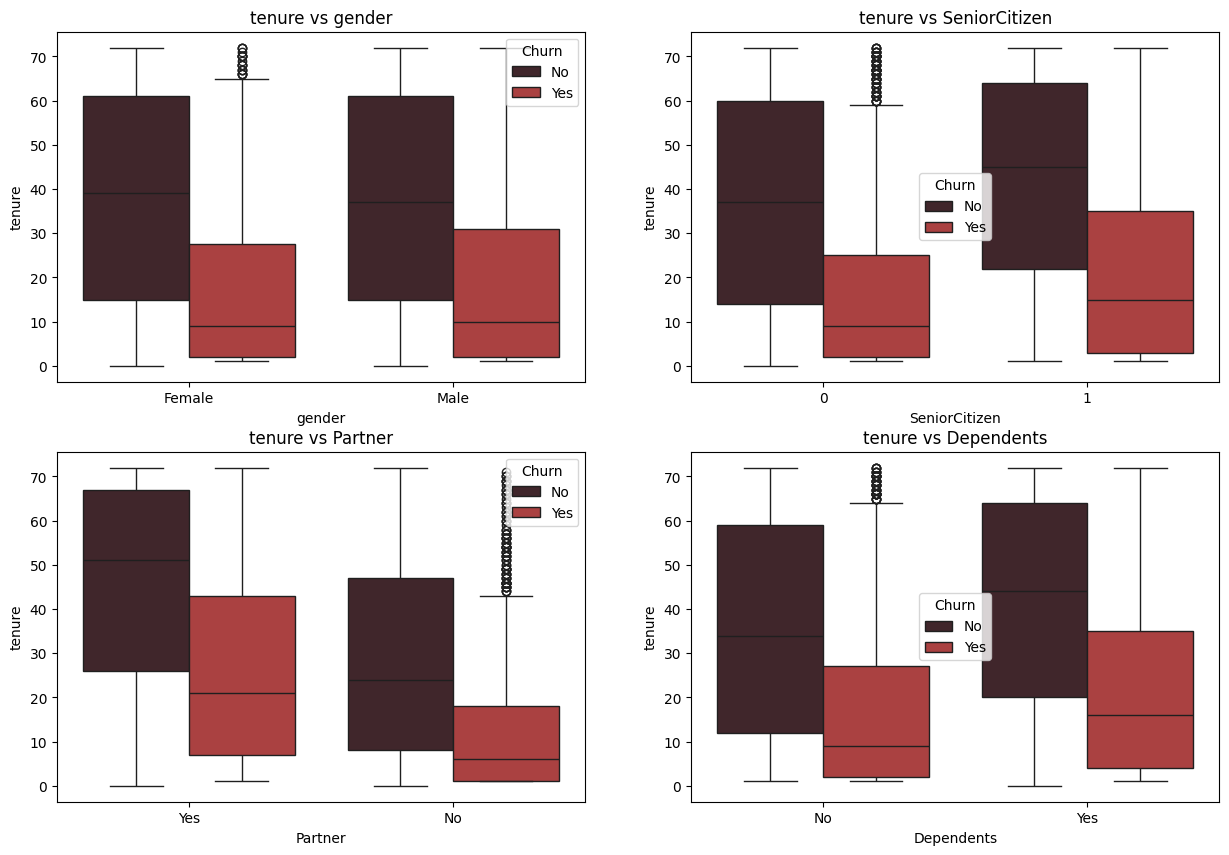

In [88]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'tenure',data = df,hue = 'Churn',palette = colors[:2]);
    plt.title('tenure vs ' + l1[i]);

- Male & Female customer churn graphs are very similar.
- SeniorCitizen opted out from the services for a tenure values of 0 - 35 months. 20 - 35 months is the kind of decision making period about whether to continue or swtich for SeniorCitizen.
- Similarly, customers with partners continued with the service for a tenure of 5 - 45 months.

##### **tenure vs Group 2: Services Subscribed by the Customer : PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies** #####


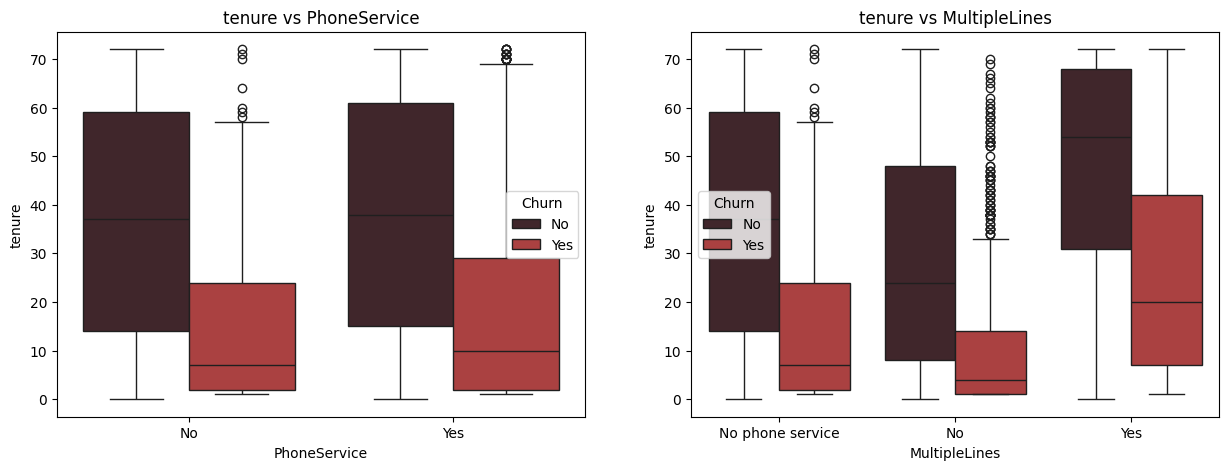

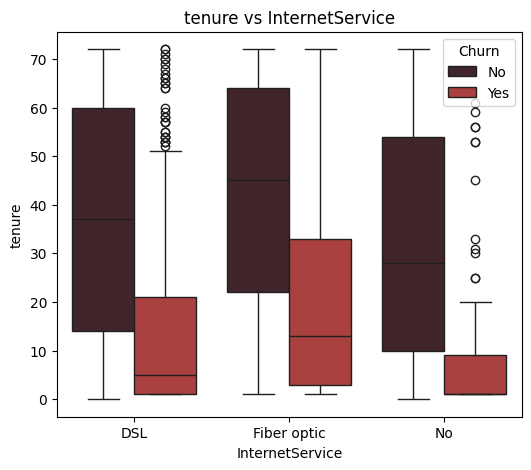

In [89]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'tenure',data = df, hue = 'Churn',palette = colors[:2]);
    plt.title('tenure vs ' + l2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'tenure',data = df, hue = 'Churn',palette = colors[:2]);
plt.title('tenure vs ' + l2[2]);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'tenure',data = df, hue = 'Churn',palette = colors[:2]);
    plt.title('tenure vs ' + l2[i + 3]);

- Presence of MutipleLines pushes the median MonthlyCharges irrespective if the customers opt out of the services or not.
- For the graph of tenure vs PhoneService, availability of PhoneService or not display a mirroring visuals. Customers were probably not heavy phone (call - message) users.
- For InternetService, customers seem to be very skeptical about the usage of Optic Fibre cables as the churning lasted for about 30 - 35 months before either carrying it forward or switching to a new one!
- Similary for StreamingTV & StreamingMovies, a churn tenure period of about 10 - 40 months can be observed!

##### **tenure vs Group 2: Services Subscribed by the Customer : OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport** #####


In [90]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'tenure',data = df, hue = 'Churn',palette = colors[:2]);
    plt.title('tenure vs ' + l2[i-4]);

- For OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport, median churn tenure value is of 25 months. The highest value of this churn tenure is of around 45 months.
- 30 - 35 month period is where the customers take a call about whether to continue with the current services or switch w.r.t above features!

##### **tenure vs Group 3 : Contract | PaperlessBilling | PaymentMethod** #####


In [91]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'tenure',data = df, hue = 'Churn',palette = colors[:2]);
    plt.title('tenure vs ' + l3[i]);

- When customers sign One year and Two year contracts for the services, they seem to continue with the services for about 25 and 45 months respectively! However, they start questioning the services and think about switching from the 35 month and 55 month mark respectively!
- Irrespective of the PaperlessBilling, customers think of switching right from the 1st month.
- When it comes to PaymentMethod, median churn tenure of Bank Transfer (automatic) & Credit Card (automatic), above 20 months, is nearly double than that of Electronic check & Mailed check, around 10 months & around 5 months respectively.

##### **MonthlyCharges vs Categorical** #####


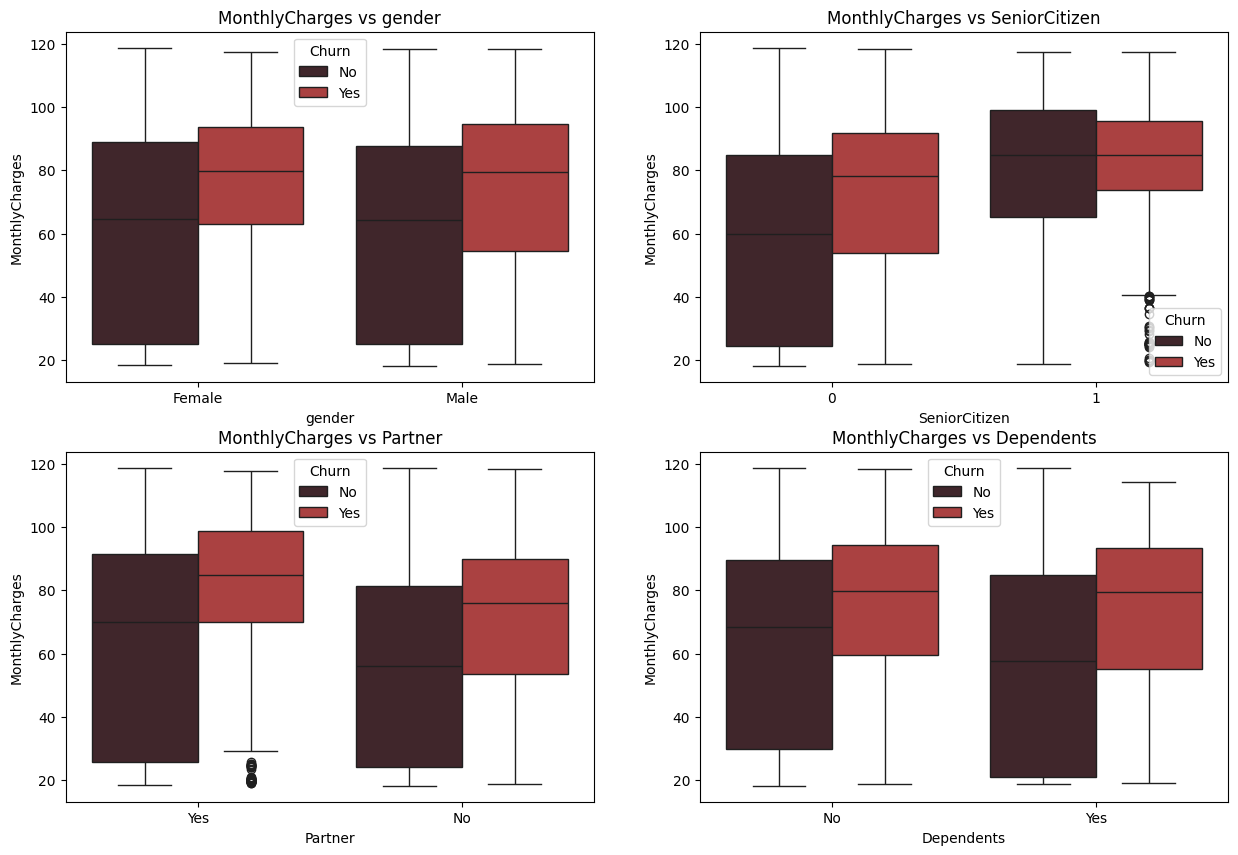

In [92]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors[:2]); 
    plt.title('MonthlyCharges vs ' + l1[i]);

- For all the features mentioned above, the median value of the not-churn customers is very close to the lower limit of the churn customers.
- Male & Female customers have the same median MonthlyCharges of around 60. For SeniorCitizen, this value is pushed to 80.
- Customers living with Partner have a higher lower limit of churning, MonthlyCharges of 70, than those living alone, MonthlyCharges of just below 60!

##### **MonthlyCharges vs Group 2: Services Subscribed by the Customer : PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies** #####


In [93]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors[:2]);
    plt.title('MonthlyCharges vs ' + l2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors[:2]);
plt.title('MonthlyCharges vs ' + l2[2]);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors[:2]);
    plt.title('MonthlyCharges vs ' + l2[i + 3]);

- MonthlyCharges of Fiber Optic cables is very high. Thus, it might be the reason for such high churn of customers.
- Similarly, MonthlyCharges of StreamingTV & StreamingMovies is quite high.
- Range of MonthlyCharges for PhoneService is from 25 - 85 but customers think of unsubscribing from 75 value of MonthlyCharges.

##### **MonthlyCharges vs Group 2: Services Subscribed by the Customer : OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport** #####


In [94]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors[:2]);
    plt.title('MonthlyCharges vs ' + l2[i-4]);

- For OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport, range of values is from around 50 to 100.
- Customers who subscribe who to these services, probably don't think about cancelling the subscription due to MonthlyCharges as the range of values of customers who unsubscribe & continue is near about the same!

##### **MonthlyCharges vs Group 3 : Contract | PaperlessBilling | PaymentMethod** #####


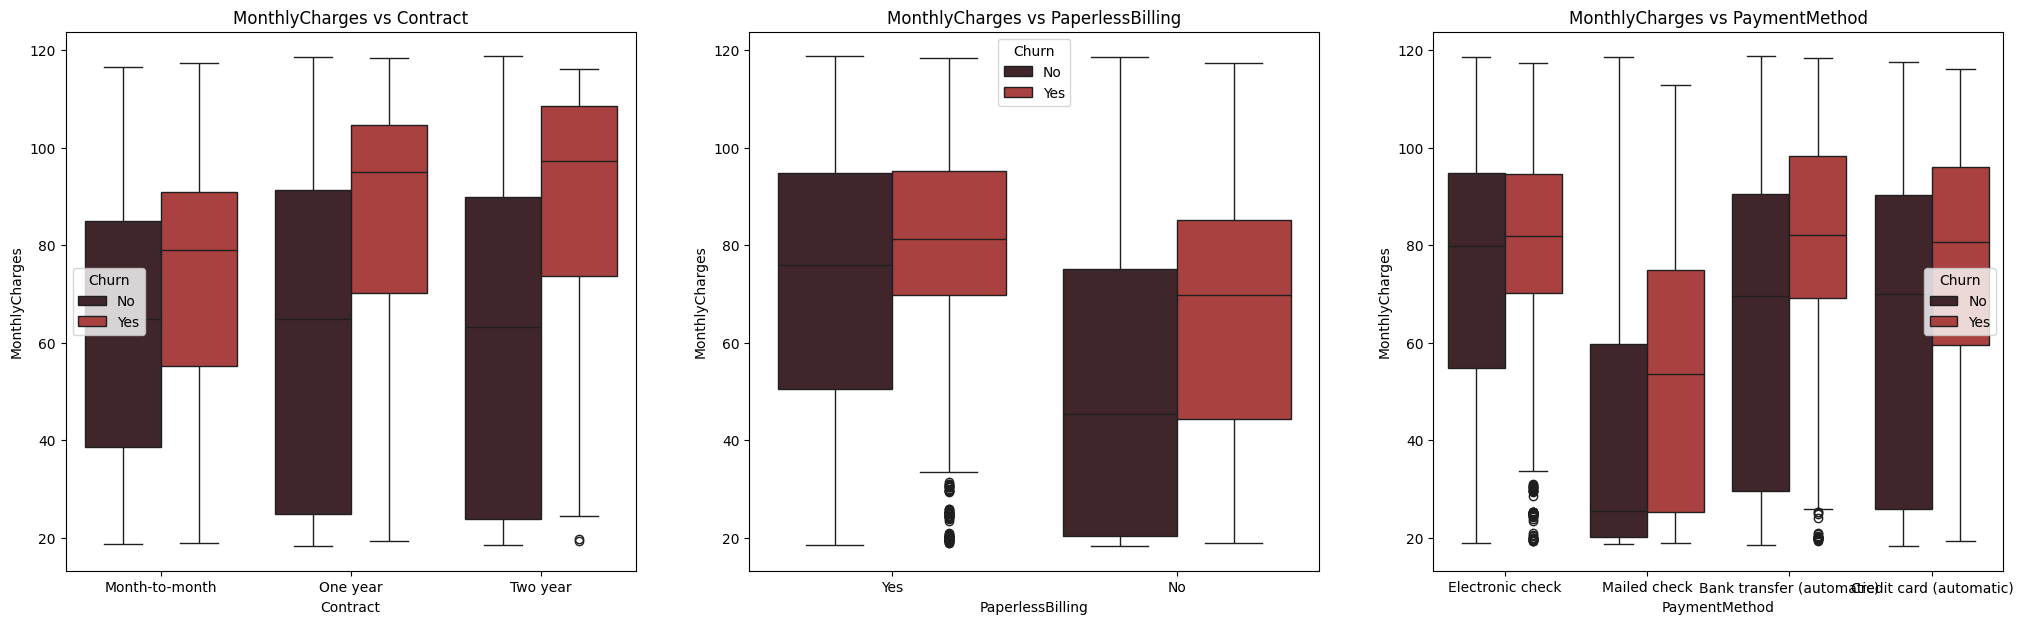

In [95]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'MonthlyCharges',data = df,hue = 'Churn',palette = colors[:2]);
    title = 'MonthlyCharges vs ' + l3[i]
    plt.title(title);

- Lower limit of the MonthlyCharges is higher for Month-to-Month contract than One year & Two year contracts. However the lower limit of the customers who discontinue the services is lower for Month-to-Month contract.
- Lower limit of the Electronic check is very high and it can be a huge factor due to which customers resent using it! Whereas Mailed check has the lowest starting values of customers who left and continued.

##### **TotalCharges vs Categorical Features :** #####


##### **TotalCharges vs Group 1 : Customer Information : gender | SeniorCitizen | Partner | Dependents** #####


In [96]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors[:2]);
    plt.title('TotalCharges vs ' + l1[i]);

- TotalCharges for male & female customers is quite the same! SeniorCitizen that continued with the services have a higher starting and closing values of TotalCharges.
- Customers housing with their Partner have a higher median value of TotalCharges as compared to those living alone!

##### **TotalCharges vs Group 2: Services Subscribed by the Customer : PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies** #####


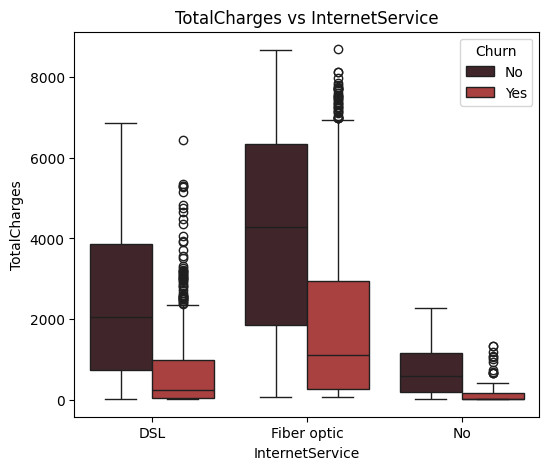

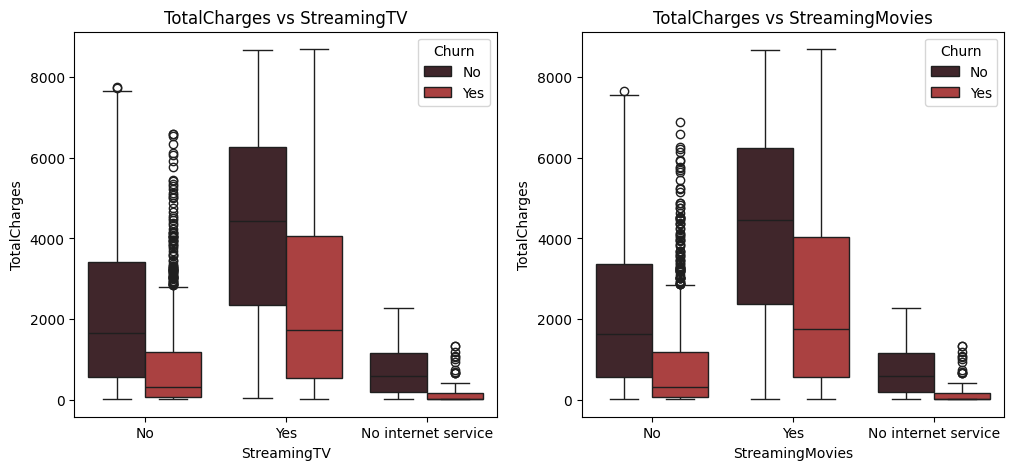

In [97]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'TotalCharges',data = df ,hue = 'Churn',palette = colors[:2]);
    plt.title('TotalCharges vs ' + l2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'TotalCharges',data = df ,hue = 'Churn',palette = colors[:2]);
plt.title('TotalCharges vs ' + l2[2]);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'TotalCharges',data = df ,hue = 'Churn',palette = colors[:2]);
    plt.title('TotalCharges vs ' + l2[i + 3]);

- TotalCharges of PhoneService range from 0 - 4000. However, customers start getting 2nd thoughts about PhoneService due to TotalCharges from around 1000.
- Similarly, customers start to hesitate to pay around 2000 for MultipleLines. However, some customers seem to be desperate for MultipleLines as they paid a value of around 6000 for it!
- When it comes to paying for Fiber Optic cables, customers test out the products by paying around 2000!
- Similar to Fiber Optic, StreamingTV & StreamingMovies, customers that continue with the services pay from 3000 - 6000.

##### **TotalCharges vs Group 2: Services Subscribed by the Customer : OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport** #####


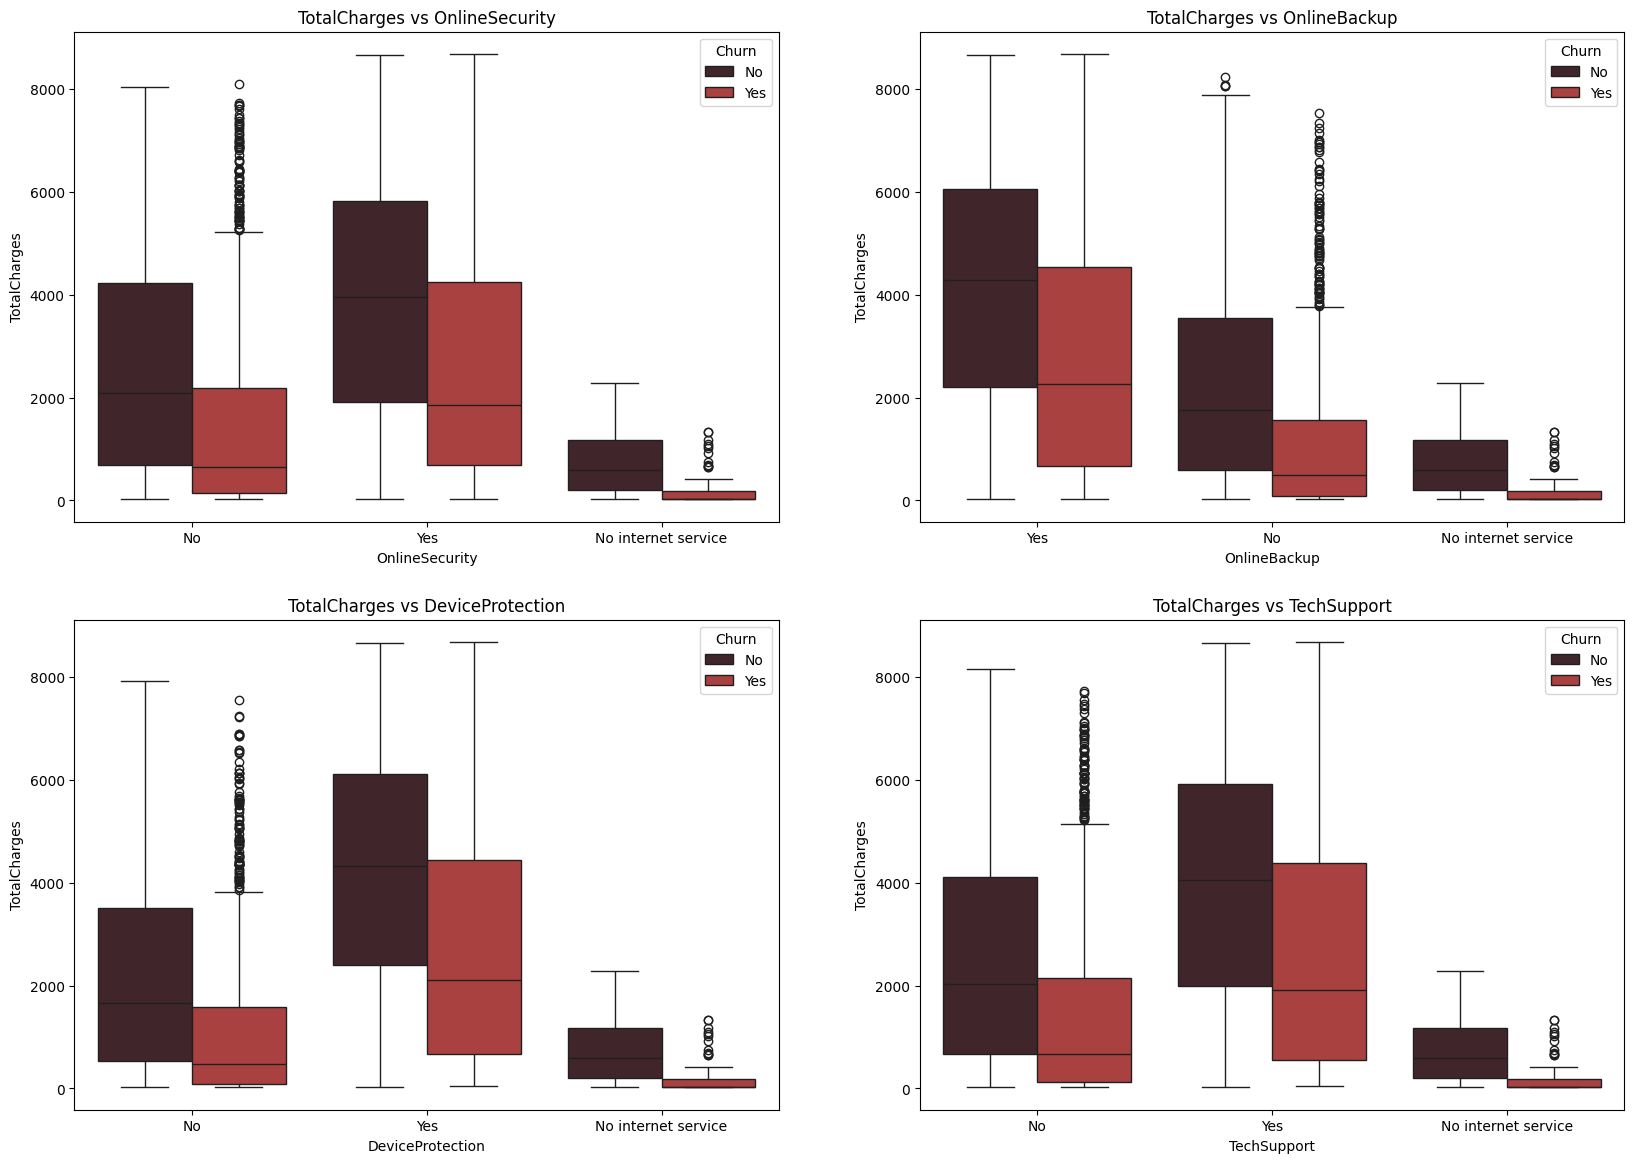

In [98]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'TotalCharges',data = df ,hue = 'Churn',palette = colors[:2]);
    plt.title('TotalCharges vs ' + l2[i-4]);

- For all the features mentioned above, customers become skeptical about paying for them around the 2000 mark. This median value of churn customers is very close to the lower limit of the customers that carry on with this service.
- Customers that do not churn out are ready to pay from 2000 - 6000 of TotalCharges.

##### **TotalCharges vs Group 3 : Contract | PaperlessBilling | PaymentMethod** #####

In [99]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'TotalCharges',data = df,hue = 'Churn',palette = colors[:2]);
    plt.title('TotalCharges vs ' + l3[i]);

- Median values of customers that decide to opt out from the services that have One year & Two year contracts is high at around 4000 & 6000. Some of the customers with Two year contracts even paid around 7000.
- For PaymentMethod, customers are skeptical to pay using Electronic check for a shorter range of 0 - 2000 whereas for Bank transfer (automatic) & Credit Card (automatic) this range is around 0 - 4000.

##### **Numerical features vs Numerical features w.r.t Target variable (Churn) :** #####


In [100]:
a = 0
fig,ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        if i != j and j > i:
            a += 1
            plt.subplot(3,1,a)
            sns.scatterplot(x = numerical_features[i],y = numerical_features[j],data = df1,hue = 'Churn',palette = colors[:2],edgecolor = 'black');
            plt.legend(['No Churn','Churn'],loc = 'upper left',)
            title = numerical_features[i] + ' vs ' + numerical_features[j]
            plt.title(title)

- For tenure of 0 - 20 months period, churning of customers quite at any MonthlyCharges values. For a tenure period from 20 - 60 months, customers at the top end of the MonthlyCharges values, 70 - 120, start to drop out from the services.
- For TotalCharges vs tenure, as tenure increases, TotalCharges increase as well! Customers opting out from their plans are the ones who are charged the highest of their tenure period alongwith a few customers whose Total Charges rank in the middle!
- Customers seemed to have decided to cancel their subscriptions when the MonthlyCharges reach 70 and above.

##### **Summary of EDA** #####


Order / Values of features for customer churn cases :
- Categorical Features (Order) :
    - gender : Male = Female
    - SeniorCitizen : No SeniorCitizen > SeniorCitizen
    - Partner : No Partner > Partner
    - Dependents : No Dependent > Dependent
    - PhoneService : PhoneService > No PhoneService
    - MultipleLines : MultipleLines > No MultipleLines > No PhoneService
    - InternetService : Fiber Optic > DSL > No InternetService
    - OnlineSecurity : Absent > Present > No InternetService
    - OnlineBackup : Absent > Present > No InternetService
    - DeviceProtection : Absent > Present > No InternetService
    - TechSupport : Absent > Present > No InternetService
    - StreamingTV : Absent > Present > No InternetService
    - StreamingMovies : Absent > Present > No InternetService
    - Contract : Month-to-Month > One year > Two year
    - PaperlessBilling : Present > Absent
    - PaymentMethod : Electronic check > Mailed check > Bank Transfer (automatic) > Credit Card (automatic)!
- Numerical Features (Range) :
    - tenure : 1 - 5 months
    - MonthlyCharges : 65 - 105
    - TotalCharges : 0 - 1000

**According to the EDA, these order / range of values results in customer churn!**

##### **Feature Engineering** #####


##### **Data Scaling** #####


In [101]:
# Usa Normalización (Min-Max Scaling) cuando necesites datos acotados (0-1) y no tengas outliers extremos (KNN, Redes Neuronales). 
# Usa Estandarización (Z-score) cuando los datos tengan distribución Gaussiana o muchos outliers, para centrar en media 0 y desviación estándar 1, 
# ideal para algoritmos sensibles a la escala (SVM, PCA, Regresión Lineal). 

In [102]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1.drop(columns = ['MonthlyCharges_Group','TotalCharges_Group'], inplace = True)

df1['tenure'] = mms.fit_transform(df1[['tenure']])
df1['MonthlyCharges'] = mms.fit_transform(df1[['MonthlyCharges']])
df1['TotalCharges'] = mms.fit_transform(df1[['TotalCharges']])
df1.head()

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0  0.013889             0   
1       1              0        0           0  0.472222             1   
2       1              0        0           0  0.027778             1   
3       1              0        0           0  0.625000             0   
4       0              0        0           0  0.027778             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2        0.115423      0.001275      0  
1                 0              3        0.385075      0.215867      0  
2                 1              3        0.354229      0.010310      1  
3                 0              0        0.239303      0.210241      0  
4                 1              2        0.521891      0.015330      1

- Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.
Eg : Age = Years; FastingBS = mg / dl; Charges = Currency

- We have 2 options for data scaling : 1) Normalization 2) Standardization. As most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.
- Normalization : tenure, MonthlyCharges and TotalCharges features are normalized as they displayed a right skewed and bimodal data distribution.
- Standardization : None of the features are standardized for the above data.

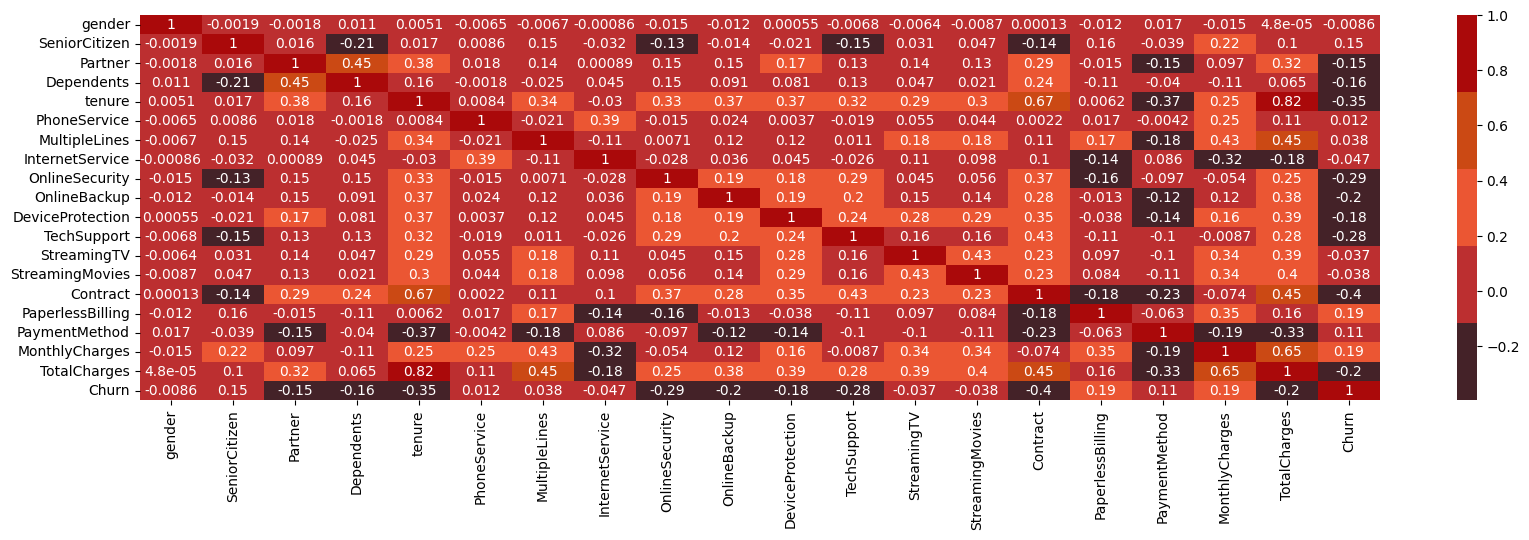

In [103]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

It is a huge matrix with too many features. We will check the correlation only with respect to Churn.

In [104]:
corr = df1.corrwith(df1['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome');

- MulipleLines, PhoneService, gender, StreamingTV, StreamingMovies and InternetService does not display any kind of correlation. We drop the features with correlation coefficient between (-0.1,0.1).
- Remaining features either display a significant positive or negative correlation.

##### **Feature Selection for Categorical Features :** #####


In [105]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif

Chi-Squared Test :

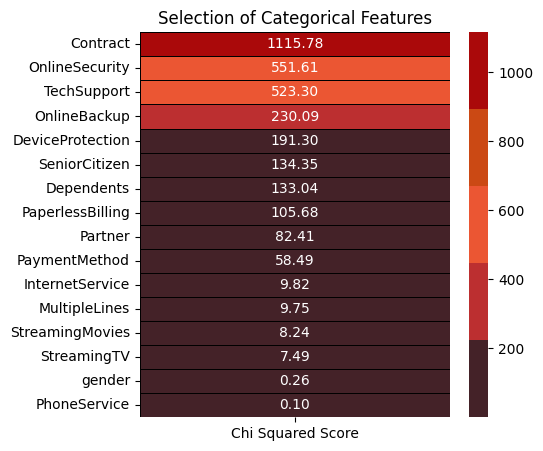

In [106]:
features = df1.loc[:,categorical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

PhoneService, gender, StreamingTV, StreamingMovies, MultipleLines and InternetService display a very low relation with Churn.

Feature Selection for Numerical Features :

In [107]:
from sklearn.feature_selection import f_classif

ANOVA Test :

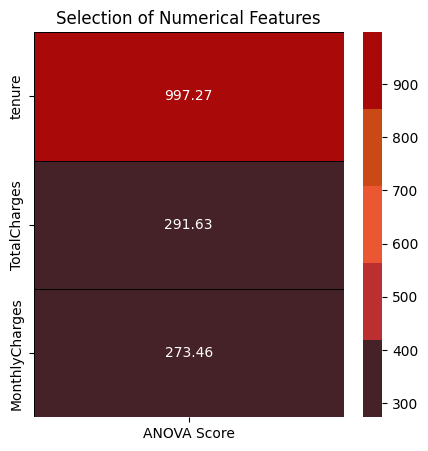

In [108]:
features = df1.loc[:,numerical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

- According to the ANOVA test, higher the value of the ANOVA score, higher the importance of the feature.
- From the above results, we need to include all the numerical features for modeling.

In [109]:
df1.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'],inplace = True)
df1.head()

SeniorCitizen  Partner  Dependents    tenure  OnlineSecurity  OnlineBackup  \
0              0        1           0  0.013889               0             2   
1              0        0           0  0.472222               2             0   
2              0        0           0  0.027778               2             2   
3              0        0           0  0.625000               2             0   
4              0        0           0  0.027778               0             0   

   DeviceProtection  TechSupport  Contract  PaperlessBilling  PaymentMethod  \
0                 0            0         0                 1              2   
1                 2            0         1                 0              3   
2                 0            0         0                 1              3   
3                 2            2         1                 0              0   
4                 0            0         0                 1              2   

   MonthlyCharges  TotalCharges  Churn  
0        0.115423      0.001275      0  
1        0.385075      0.215867      0  
2        0.354229      0.010310      1  
3        0.239303      0.210241      0  
4        0.521891      0.015330      1

**We will now move onto data balancing!**

- Data Balancing using SMOTE :¶
In order to cope with unbalanced data, there are 2 options :

- Undersampling : Trim down the majority samples of the target variable.
    - Oversampling : Increase the minority samples of the target variable to the majority samples.
    - After doing trial-error with undersampling & oversampling, we have decided to go with oversampling!
- For data balancing, we will use imblearn.
pip statement : pip install imbalanced-learn

In [110]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [111]:
over = SMOTE(sampling_strategy = 1)

f1 = df1.iloc[:,:13].values
t1 = df1.iloc[:,13].values

f1, t1 = over.fit_resample(f1, t1)
Counter(t1)

Counter({np.int64(0): 5174, np.int64(1): 5174})

##### **Modeling** #####


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay  # Updated import
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [113]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.20, random_state = 2)


Selecting the features from the above conducted tests and splitting the data into 80 - 20 train - test groups.


In [114]:
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    RocCurveDisplay.from_estimator(classifier, x_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

1] Xgboost Classifier :

In [115]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

Cross Validation Score :  90.32%
ROC_AUC Score :  82.48%


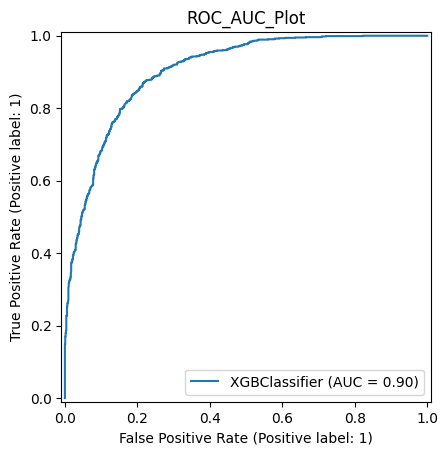

In [116]:
model(classifier_xgb,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1040
           1       0.80      0.86      0.83      1030

    accuracy                           0.82      2070
   macro avg       0.83      0.82      0.82      2070
weighted avg       0.83      0.82      0.82      2070



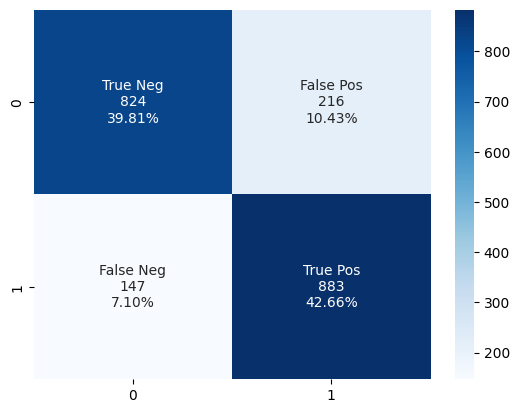

In [117]:
model_evaluation(classifier_xgb,x_test,y_test)

2] LightGBM Classifier 

In [118]:
from lightgbm import LGBMClassifier

classifier_lgbm = LGBMClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000, verbose=-1)

Cross Validation Score :  90.50%
ROC_AUC Score :  83.06%


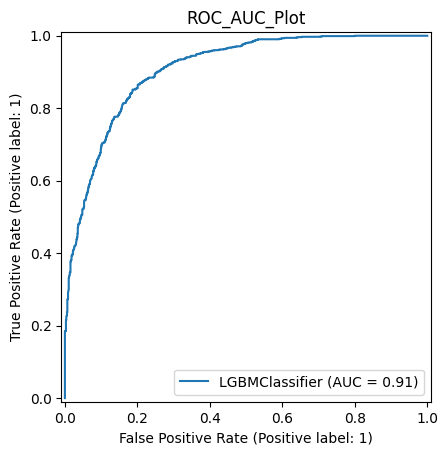

In [119]:
model(classifier_lgbm,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1040
           1       0.81      0.87      0.84      1030

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



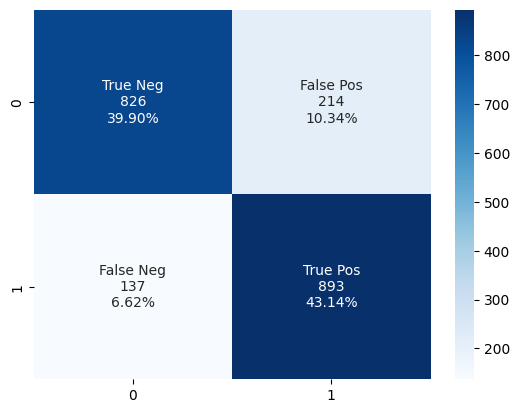

In [120]:
model_evaluation(classifier_lgbm,x_test,y_test)

3] Random Forest Classifier :

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)

Cross Validation Score :  85.49%
ROC_AUC Score :  78.29%


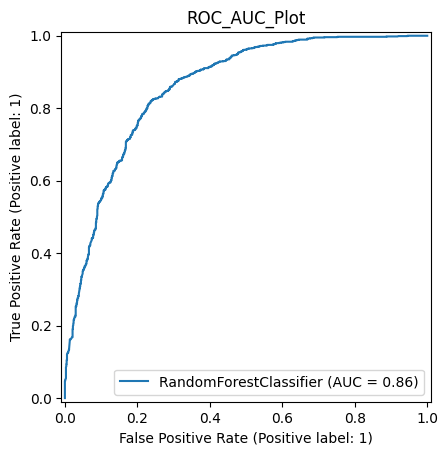

In [123]:
model(classifier_rf,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1040
           1       0.75      0.85      0.80      1030

    accuracy                           0.78      2070
   macro avg       0.79      0.78      0.78      2070
weighted avg       0.79      0.78      0.78      2070



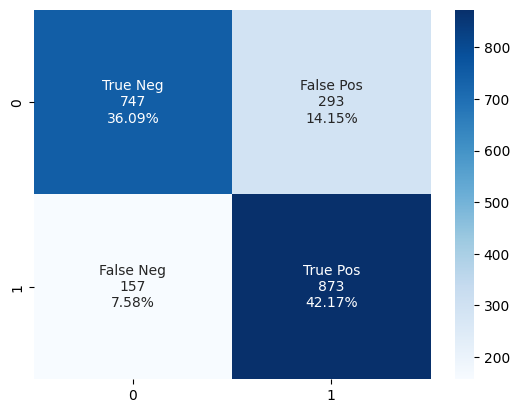

In [124]:
model_evaluation(classifier_rf,x_test,y_test)

4] Decision Tree Classifier

In [125]:
from sklearn.tree import DecisionTreeClassifier

In [126]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)

Cross Validation Score :  83.56%
ROC_AUC Score :  76.81%


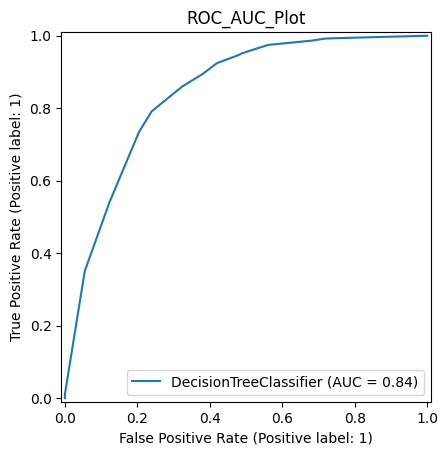

In [127]:
model(classifier_dt,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1040
           1       0.72      0.86      0.79      1030

    accuracy                           0.77      2070
   macro avg       0.78      0.77      0.77      2070
weighted avg       0.78      0.77      0.77      2070



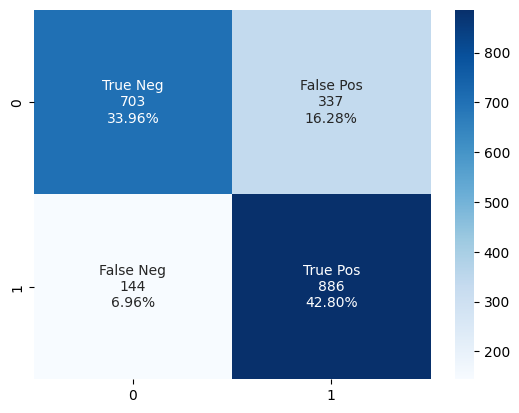

In [128]:
model_evaluation(classifier_dt,x_test,y_test)

5] Stack of XGBClassifier, LightGBMClassifier, Random Forest Classifer & Decision Tree Classifier :

In [129]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('classifier_xgb',classifier_xgb),
                                         ('classifier_lgbm',classifier_lgbm),
                                         ('classifier_rf',classifier_rf),
                                         ('classifier_dt',classifier_dt)],
                           final_estimator = classifier_lgbm)

- For stacking of classifiers, we stack the above 4 classifiers :
    -   XGBClassifier
    -   LightGBMClassifier
    -   RandomForestClassifier
    -   DecisionTreeClassifier

- It has an important hyperparameter known as final_estimator. It is the classifier that makes the final prediction by using the predicted classes by the various classifier and predicts the final output.

Cross Validation Score :  91.00%
ROC_AUC Score :  83.20%


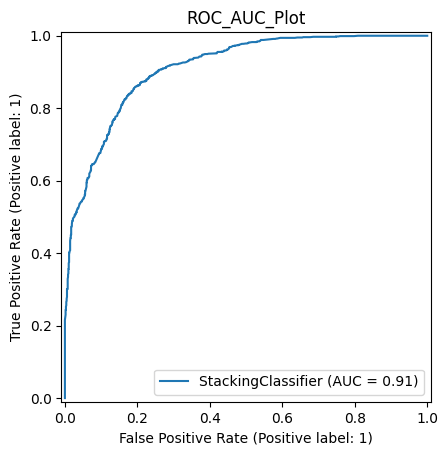

In [130]:
model(stack,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1040
           1       0.81      0.86      0.84      1030

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



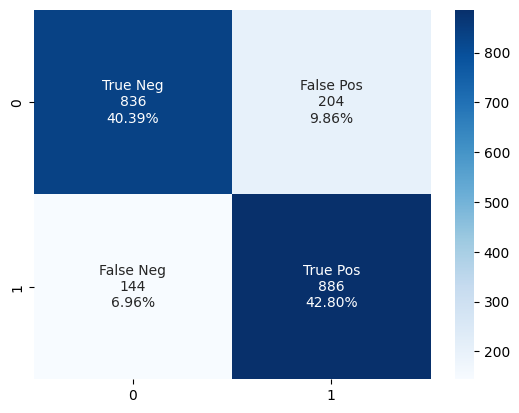

In [131]:
model_evaluation(stack,x_test,y_test)

In [132]:
# Create the new customer data
new_customer = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 15,
    'PhoneService': 'Yes',
    'MultipleLines': 'Yes',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'Yes',
    'TechSupport': 'Yes',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'No',
    'Contract': 'One year',
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.7,
    'TotalCharges': 180
}

# Convert to DataFrame
new_customer_df = pd.DataFrame([new_customer])

# PREPROCESSING - Apply the same transformations as training data
new_customer_processed = new_customer_df.copy()

# Step 1: Label Encoding for categorical features
categorical_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'Contract', 
                        'PaperlessBilling', 'PaymentMethod']

le = LabelEncoder()
for feature in categorical_features:
    if feature in new_customer_processed.columns:
        new_customer_processed[feature] = le.fit_transform(new_customer_processed[feature])

# Encode SeniorCitizen (it's already numeric but ensure it's int)
new_customer_processed['SeniorCitizen'] = new_customer_processed['SeniorCitizen'].astype(int)

# Step 2: Scale numerical features
mms = MinMaxScaler()
new_customer_processed['tenure'] = mms.fit_transform(new_customer_processed[['tenure']])
new_customer_processed['MonthlyCharges'] = mms.fit_transform(new_customer_processed[['MonthlyCharges']])
new_customer_processed['TotalCharges'] = mms.fit_transform(new_customer_processed[['TotalCharges']])

# Step 3: Drop the same columns you dropped during training
columns_to_drop = ['PhoneService', 'gender', 'StreamingTV', 'StreamingMovies', 
                   'MultipleLines', 'InternetService']
new_customer_processed.drop(columns=columns_to_drop, inplace=True)

# Step 4: Ensure columns are in the correct order (same as training)
# Get the feature names from your training data
expected_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
                   'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

new_customer_processed = new_customer_processed[expected_columns]

# Step 5: Make prediction using 'stack' (not 'classifier_stack')
prediction = stack.predict(new_customer_processed)
prediction_proba = stack.predict_proba(new_customer_processed)

# Display results
print("=" * 50)
print("CHURN PREDICTION FOR NEW CUSTOMER")
print("=" * 50)
print(f"Will the customer churn? {'YES' if prediction[0] == 1 else 'NO'}")
print(f"Probability of NOT churning: {prediction_proba[0][0]:.2%}")
print(f"Probability of CHURNING: {prediction_proba[0][1]:.2%}")
print("=" * 50)

if prediction_proba[0][1] > 0.5:
    print("\n⚠️  HIGH RISK: This customer is likely to churn!")
else:
    print("\n✓ LOW RISK: This customer is likely to stay.")

CHURN PREDICTION FOR NEW CUSTOMER
Will the customer churn? NO
Probability of NOT churning: 72.75%
Probability of CHURNING: 27.25%

✓ LOW RISK: This customer is likely to stay.
